# Sampling

**Goal:** ...
  
This notebook is divided in two parts:
* **1. Bla**

In [2]:
%run ../setup_environment.ipy
%run ../Selene_Job.ipy

Setup environment... done!


<span style="color:green">✅ Working on **impact-annotator_env** conda environment.</span>

In [2]:
summary = pd.DataFrame(columns=['test_accuracy_mean', 'test_roc_auc_mean', 'test_f1_mean', 'test_average_precision_mean',
                                'test_accuracy_std' , 'test_roc_auc_std' , 'test_f1_std' , 'test_average_precision_std'])
summary.index.name = 'sampling_strategy'

## Get the data

In [3]:
features = ['t_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage', 'frequency_in_normals',
            'VEP_Consequence', 'VEP_VARIANT_CLASS', 'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_COSMIC_CNT', 'VEP_gnomAD_AF', 'VEP_in_dbSNP',
            'VEP_gnomAD_total_AF_AFR', 'VEP_gnomAD_total_AF_AMR', 'VEP_gnomAD_total_AF_ASJ', 'VEP_gnomAD_total_AF_EAS', 'VEP_gnomAD_total_AF_FIN',
            'VEP_gnomAD_total_AF_NFE', 'VEP_gnomAD_total_AF_OTH', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF', 'Kaviar_AF',
            'gene_type']

# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)
impact = get_impact_ready_for_classification(impact, 'is_artefact', features)

In [4]:
def get_seeded_negative_class_X_and_y(impact, label, seed):
    positive_class_number = impact[impact.is_artefact].shape[0]

    X, y = get_X_and_y(impact, label, range(seed * positive_class_number, (seed + 1) * positive_class_number))
    print(X.shape)
    print(y.shape)
    display(get_table(y))
    
    return X, y

In [5]:
X_1, y_1 = get_seeded_negative_class_X_and_y(impact, 'is_artefact', 0)
X_2, y_2 = get_seeded_negative_class_X_and_y(impact, 'is_artefact', 1)
X_3, y_3 = get_seeded_negative_class_X_and_y(impact, 'is_artefact', 2)

(14398, 45)
(14398,)


,count_,freq_
True,7199,50.0%
False,7199,50.0%


(14398, 45)
(14398,)


,count_,freq_
True,7199,50.0%
False,7199,50.0%


(14398, 45)
(14398,)


,count_,freq_
True,7199,50.0%
False,7199,50.0%


In [6]:
dataset_dict = {'sampling_1': {'X': X_1, 'y': y_1, 'metrics': pd.DataFrame()},
                'sampling_2': {'X': X_2, 'y': y_2, 'metrics': pd.DataFrame()},
                'sampling_3': {'X': X_3, 'y': y_3, 'metrics': pd.DataFrame()}}

## Set cross-validation strategies

We choose stratified folds (made by preserving the percentage of samples for each class) for both outer and nested cross-validation.

In [7]:
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

## Ridge Regression (L2 regularization)

In [8]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'] = run_model(model, dataset_dict[key]['X'], dataset_dict[key]['y'], cv_strategy, n_jobs=5)
    print_mean_metrics(dataset_dict[key]['metrics'])

**sampling_1**

Run model... done! (5.33s)
▴ Mean accuracy    : 0.820 ± 0.006
▴ Mean ROC AUC     : 0.891 ± 0.010
▴ Mean F1-score    : 0.803 ± 0.011
▴ Average precision: 0.912 ± 0.006


**sampling_2**

Run model... done! (3.92s)
▴ Mean accuracy    : 0.819 ± 0.020
▴ Mean ROC AUC     : 0.887 ± 0.019
▴ Mean F1-score    : 0.801 ± 0.022
▴ Average precision: 0.912 ± 0.015


**sampling_3**

Run model... done! (3.79s)
▴ Mean accuracy    : 0.866 ± 0.016
▴ Mean ROC AUC     : 0.926 ± 0.016
▴ Mean F1-score    : 0.858 ± 0.019
▴ Average precision: 0.943 ± 0.012


**sampling_1**

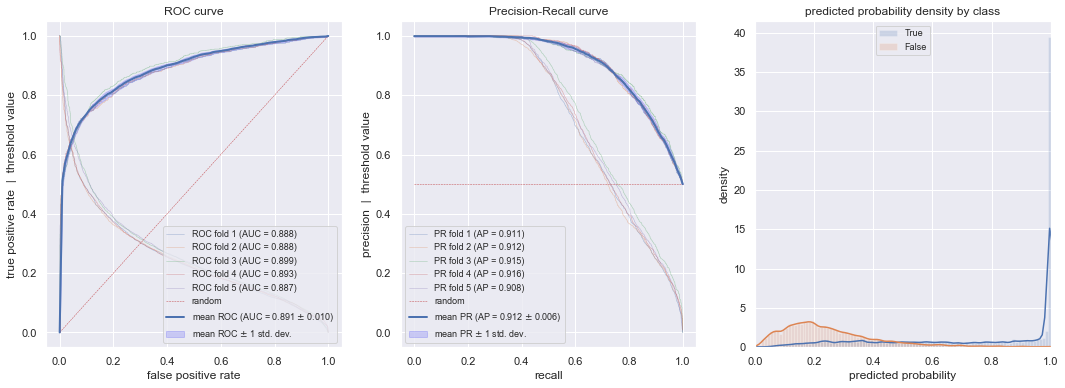

**sampling_2**

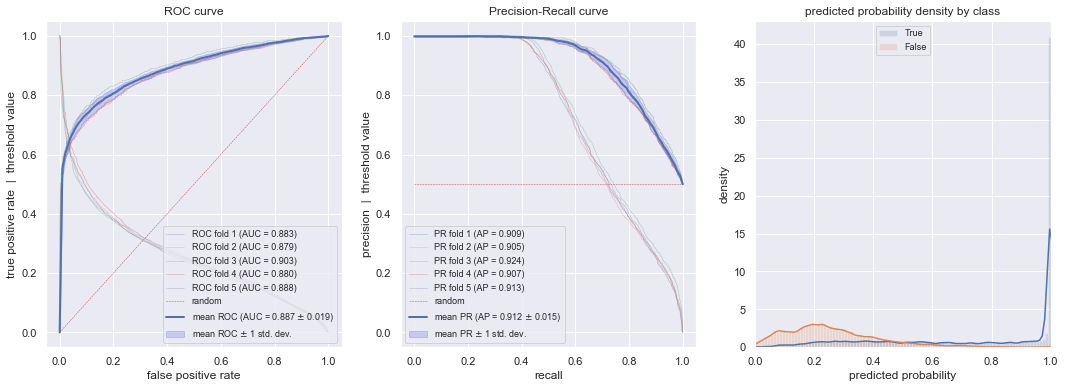

**sampling_3**

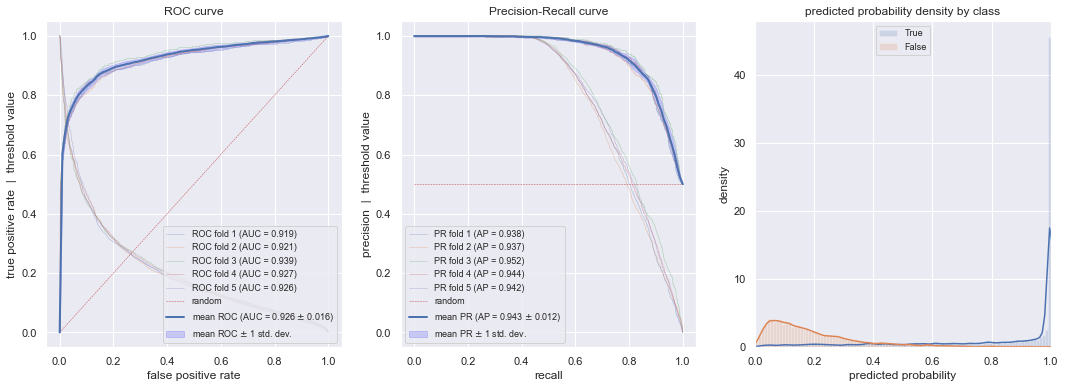

In [9]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_threshold_decision_metrics(dataset_dict[key]['metrics'], figsize=(18, 6))
    plt.show()

**sampling_1**

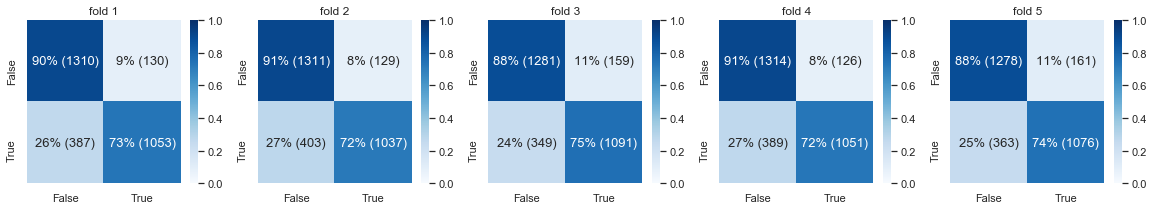

**sampling_2**

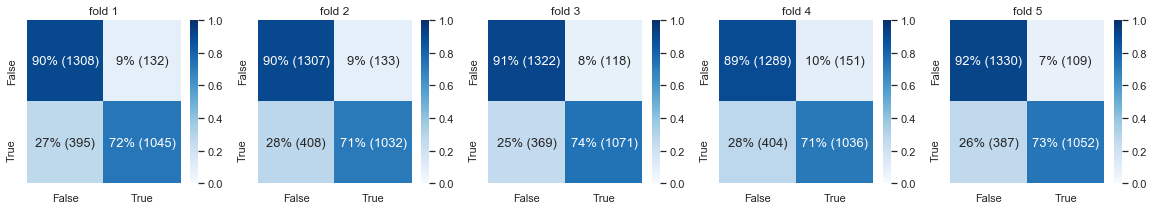

**sampling_3**

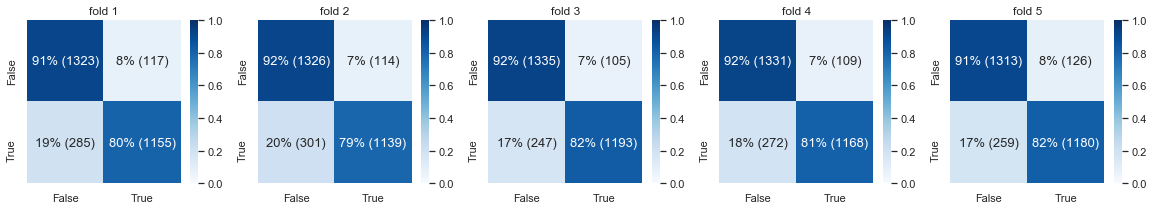

In [10]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_confusion_matrix(dataset_dict[key]['metrics'])
    plt.show()

In [11]:
for key in dataset_dict.keys():
    add_metrics_to_summary(summary, dataset_dict[key]['metrics'], 'RidgeRegression_%s' % key)

## Random Forest

### Create job

In [ ]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs'))

In [12]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ job found and reloaded

In [ ]:
for job in job_list:
    job.load_data(dataset_dict[job.job_id[13:]]['X'], dataset_dict[job.job_id[13:]]['y'])

In [ ]:
%%writefile {job_list[0].script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=10)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

In [47]:
!cp {job_list[0].script_path} {job_list[1].script_path}
!cp {job_list[0].script_path} {job_list[2].script_path}

In [48]:
for job in job_list:
    job.run(n_jobs=10, short_job=True, memory=16)

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_1 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1535     1.5KB/s   00:01    
metrics.pkl                                   100%  477KB 612.5KB/s   00:00    
script.ipy                                    100%  925     0.9KB/s   00:01    
X.pkl                                         100% 3268KB   3.9MB/s   00:00    
y.pkl                                         100%   15KB  24.1KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_1
Job <28725787> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_1 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_2 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1535     3.1KB/s   00:00    
metrics.pkl                                   100%  497KB 824.2KB/s   00:00    
script.ipy                                    100%  925     0.9KB/s   00:01    
X.pkl                                         100% 3268KB   3.5MB/s   00:00    
y.pkl                                         100%   15KB 878.5KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_2
Job <28725789> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_2 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"

<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_sampling_3 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
job_output.txt                                100% 1535     1.5KB/s   00:01    
metrics.pkl                                   100%  453KB 553.5KB/s   00:00    
script.ipy                                    100%  925     1.3KB/s   00:00    
X.pkl                                         100% 3268KB   3.2MB/s   00:01    
y.pkl                                         100%   15KB  92.3KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_3
Job <28725791> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_sampling_3 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"

<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ submitted<br>

In [13]:
for job in job_list:
    job.get_results()

<span style="color:green">Job < RandomForest_sampling_1 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_1 to ../ssh_remote_jobs/job_RandomForest_sampling_1
metrics.pkl                                   100%  472KB   5.1MB/s   00:00    
job_output.txt                                100% 1533   265.3KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.864 ± 0.008
▴ Mean ROC AUC     : 0.937 ± 0.009
▴ Mean F1-score    : 0.859 ± 0.008
▴ Average precision: 0.948 ± 0.007


<span style="color:green">Job < RandomForest_sampling_2 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_2 to ../ssh_remote_jobs/job_RandomForest_sampling_2
metrics.pkl                                   100%  492KB   5.4MB/s   00:00    
job_output.txt                                100% 1533   395.0KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.860 ± 0.015
▴ Mean ROC AUC     : 0.933 ± 0.011
▴ Mean F1-score    : 0.853 ± 0.016
▴ Average precision: 0.944 ± 0.010


<span style="color:green">Job < RandomForest_sampling_3 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_sampling_3 to ../ssh_remote_jobs/job_RandomForest_sampling_3
metrics.pkl                                   100%  447KB   5.0MB/s   00:00    
job_output.txt                                100% 1531   309.4KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.896 ± 0.013
▴ Mean ROC AUC     : 0.958 ± 0.009
▴ Mean F1-score    : 0.894 ± 0.014
▴ Average precision: 0.964 ± 0.008


**RandomForest_sampling_1**

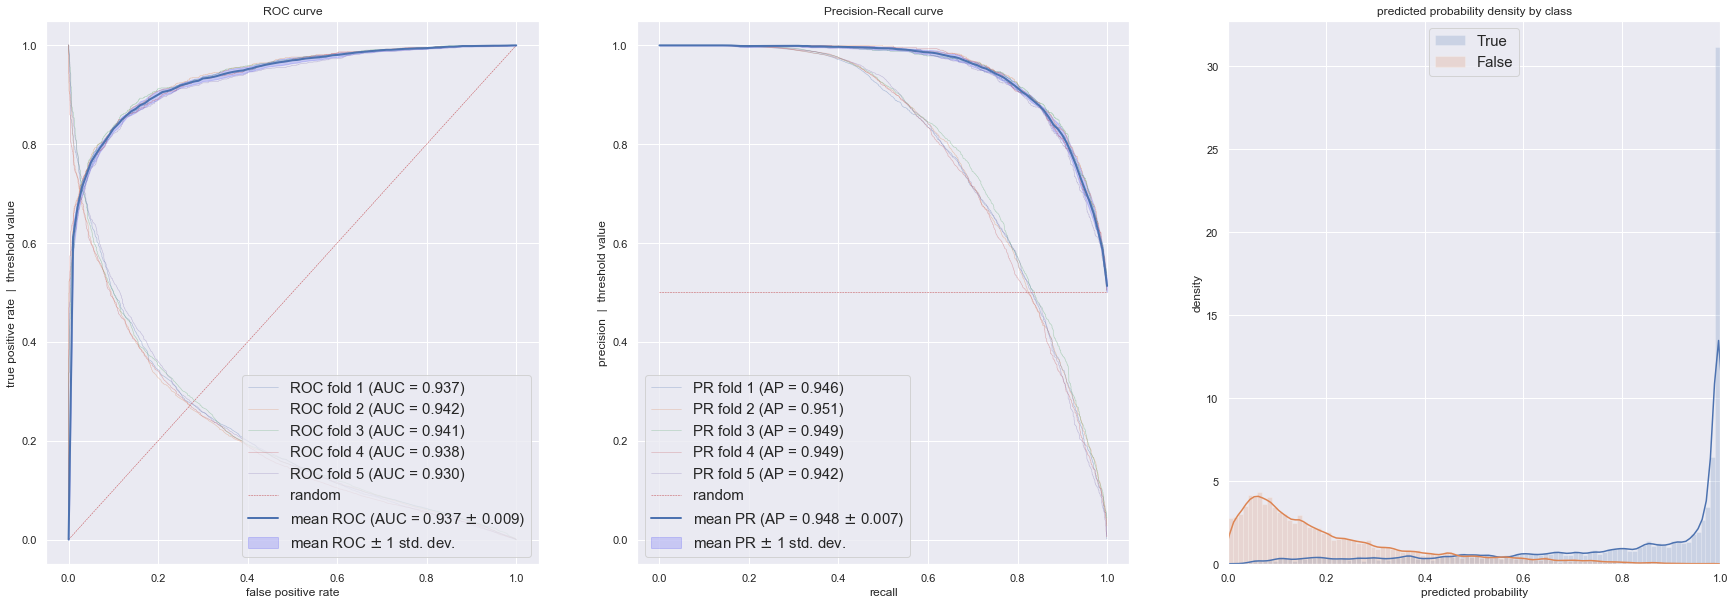

**RandomForest_sampling_2**

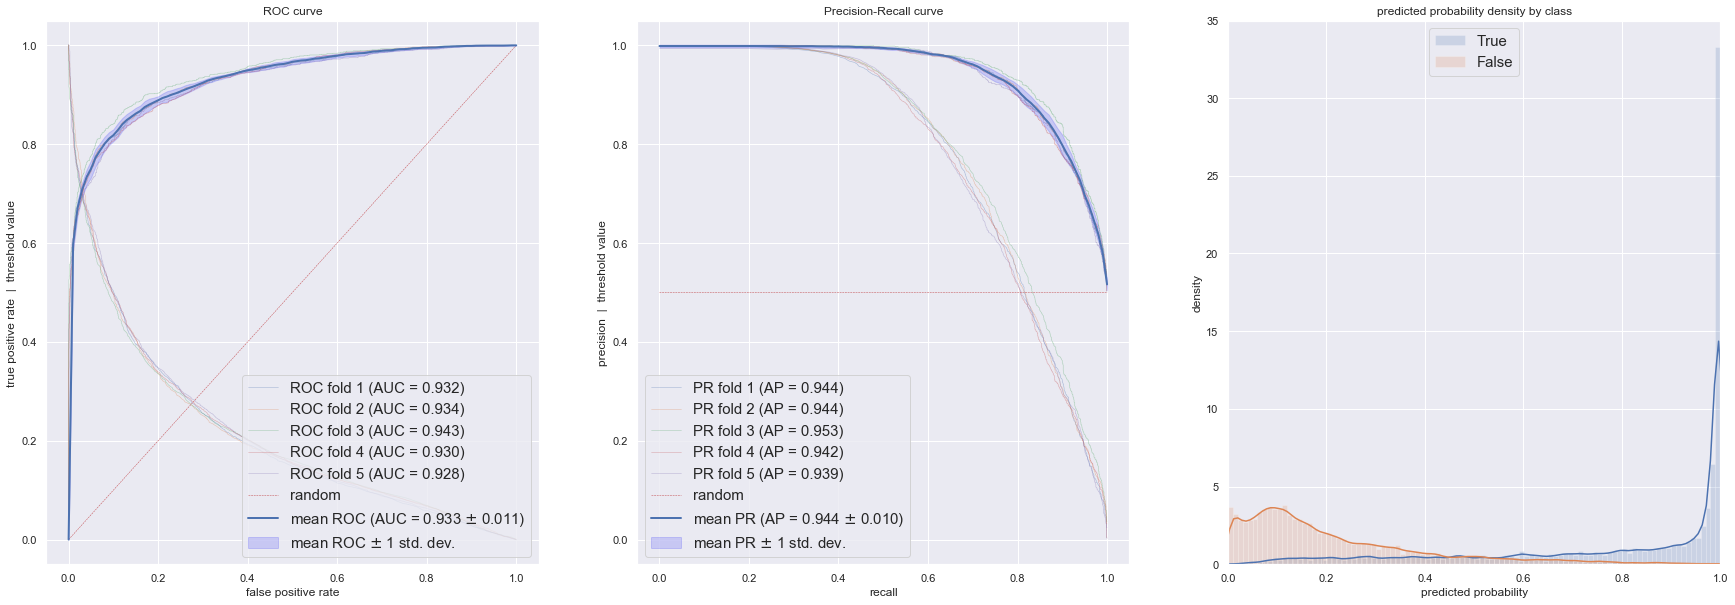

**RandomForest_sampling_3**

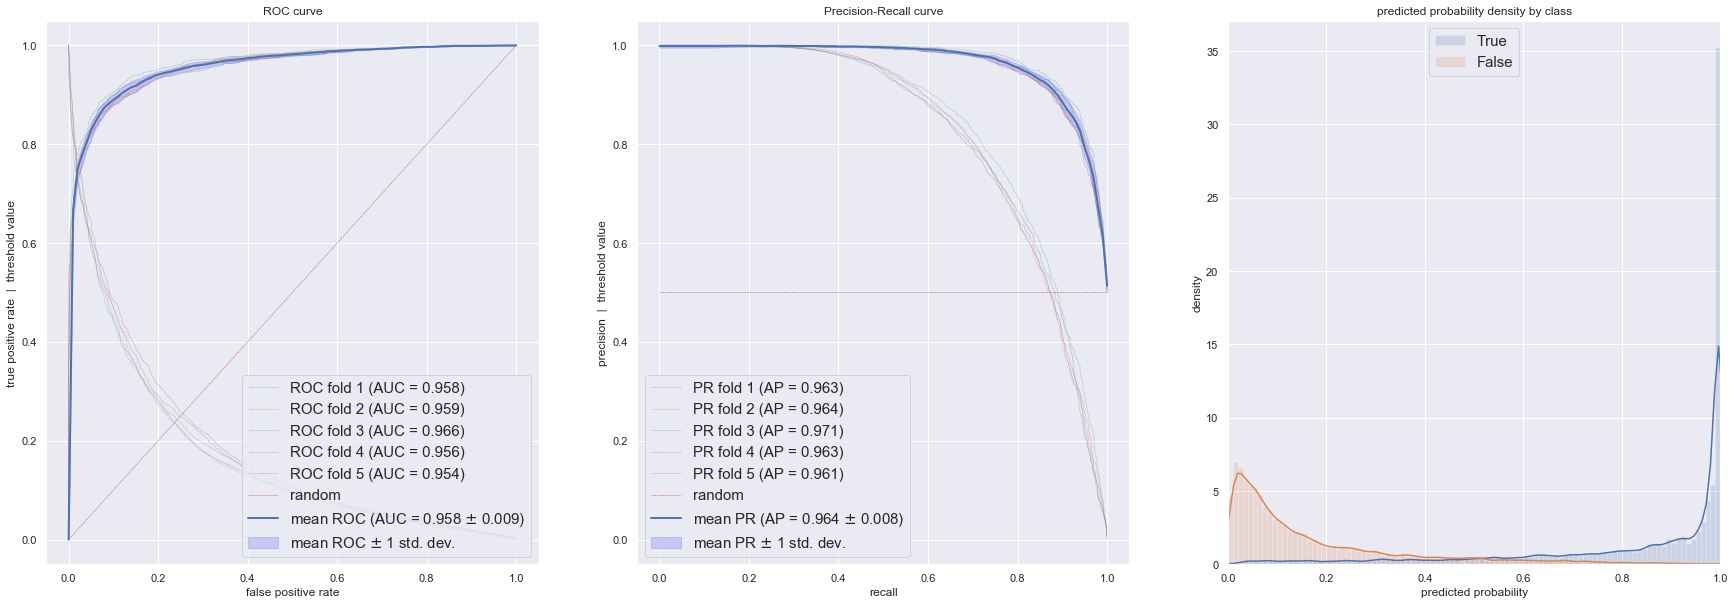

In [14]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_threshold_decision_metrics(job.metrics)
        plt.show()

**RandomForest_sampling_1**

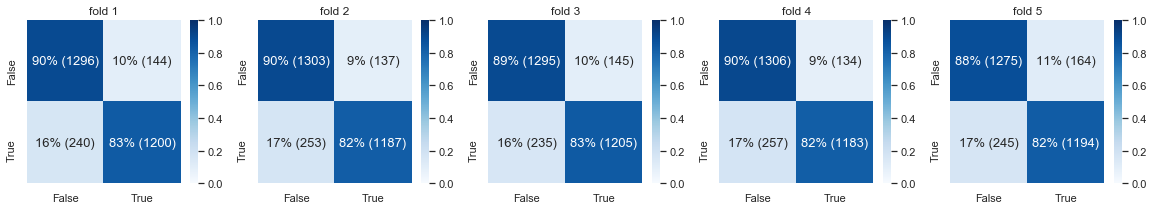

**RandomForest_sampling_2**

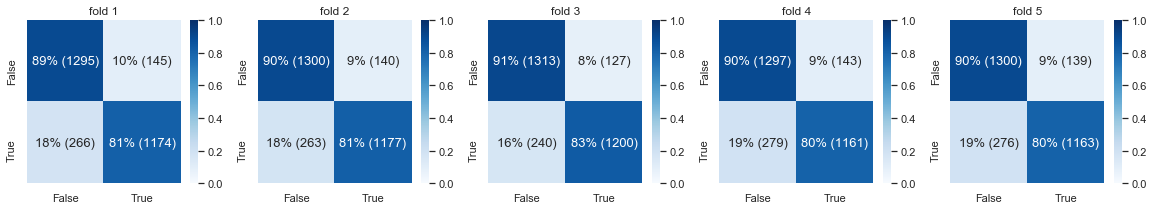

**RandomForest_sampling_3**

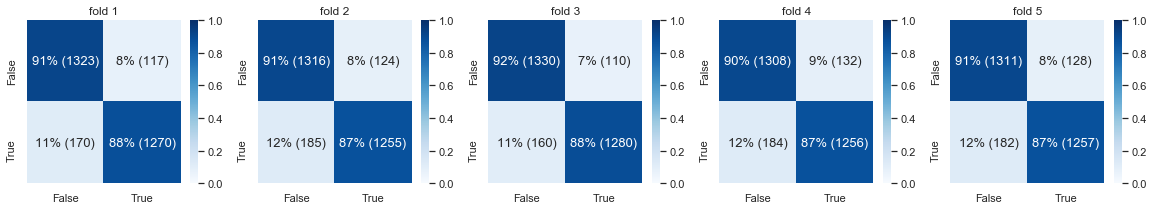

In [15]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_confusion_matrix(job.metrics)
        plt.show()

In [16]:
for job in job_list:
    if hasattr(job, 'metrics'):
        add_metrics_to_summary(summary, job.metrics, job.job_id)

### Study feature importance of the best hyperparameted classifier

**sampling_1**

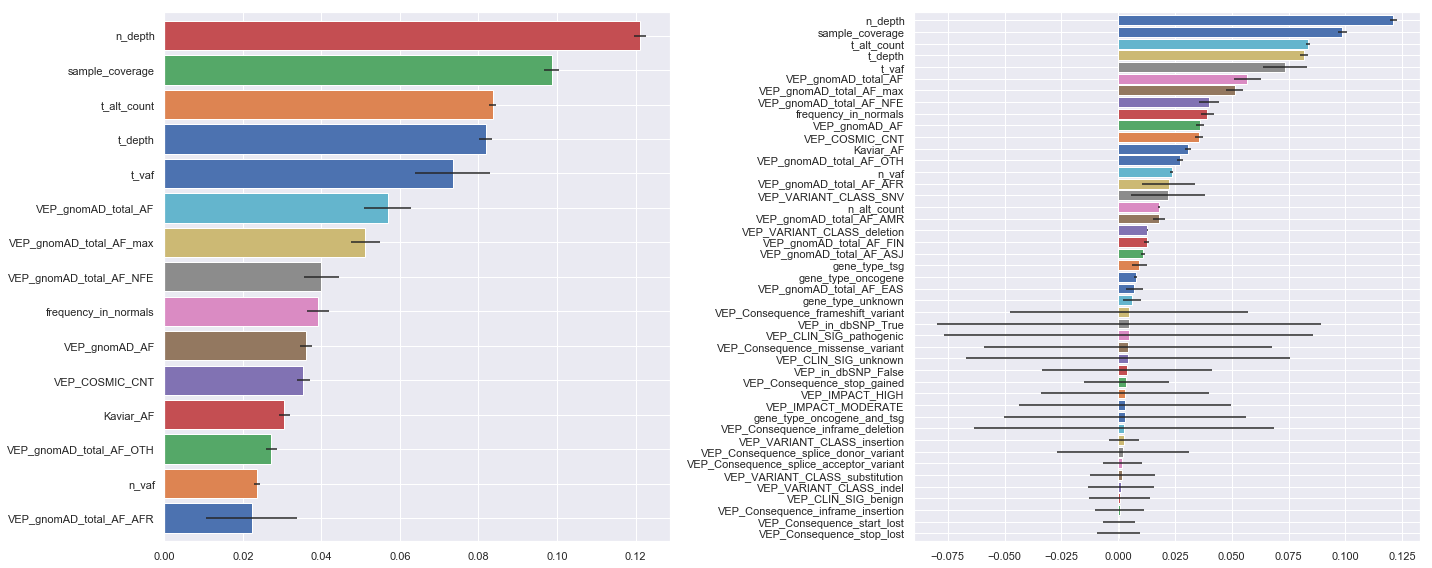

**sampling_2**

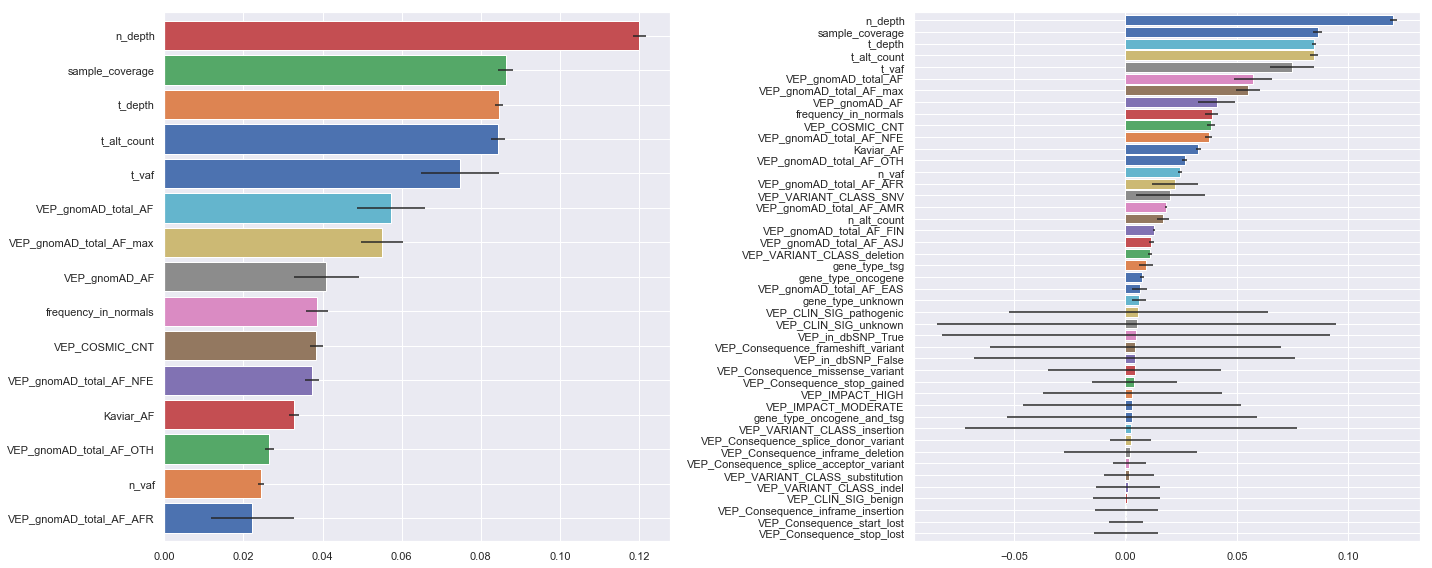

**sampling_3**

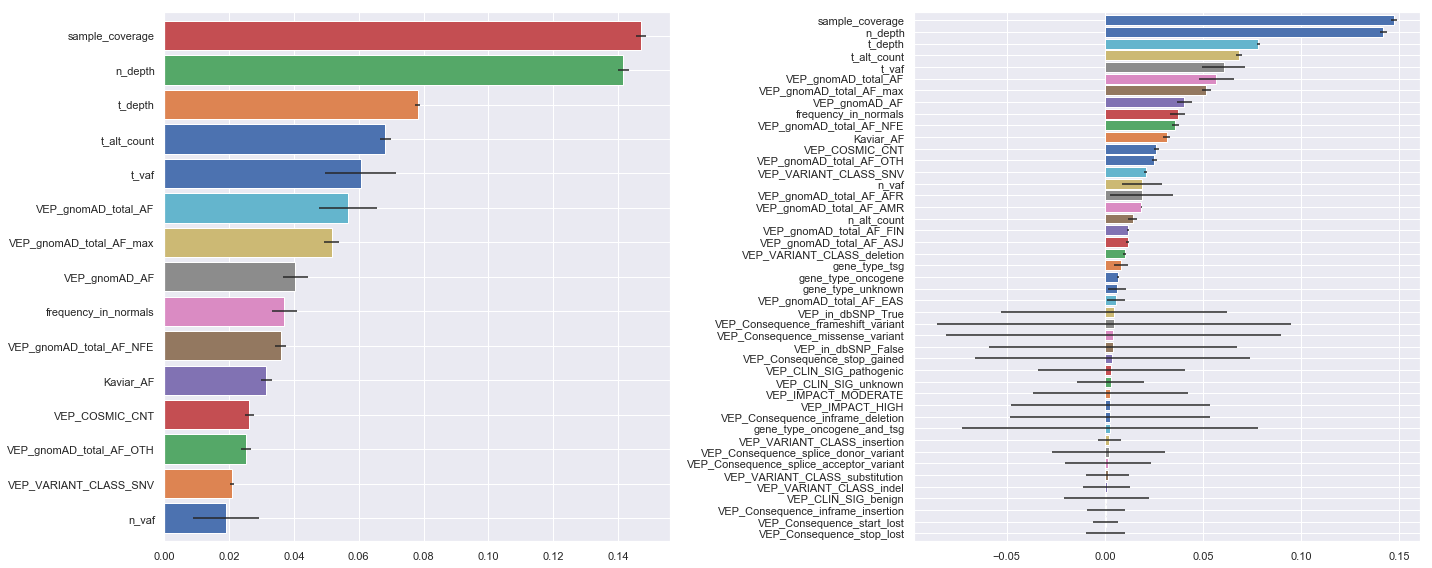

In [17]:
from sklearn.ensemble import RandomForestClassifier

model_bestRF = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy', n_jobs=5)

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_features_importance(model_bestRF, dataset_dict[key]['X'], dataset_dict[key]['y'], random_forest=True)
    plt.show()

## Get the data - unified IMPACT

In [18]:
# get raw data
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
print(impact.shape)
display(get_table(impact.is_artefact))

(194211, 64)


,count_,freq_
False,187012,96.3%
True,7199,3.7%


In [19]:
def get_random_sample(x, max_number):
    if x.shape[0] > max_number:
        return x.sample(max_number, random_state=42).tolist()
    else:
        return x.tolist()

aggregation = {
    'mut_key': {'number': 'count'},
    
    'sample_mut_key': {'list': lambda x: x.tolist(),
                       'selected': lambda x: get_random_sample(x, 3)}
}

dd = impact.groupby('mut_key').aggregate(aggregation)
dd.head(10)

/Users/guilminp/anaconda3/lib/python3.6/site-packages/pandas/core/groupby/groupby.py:4656: FutureWarning: using a dict with renaming is deprecated and will be removed in a future version
  return super(DataFrameGroupBy, self).aggregate(arg, *args, **kwargs)


mut_key  \
                                  number   
mut_key                                    
10_104263912_G_A                       1   
10_104263932_GCGCCCCCGGCCCCACC_-       2   
10_104263935_C_-                       1   
10_104263935_C_T                       1   
10_104263941_G_A                       3   
10_104263952_C_-                       1   
10_104263959_C_T                       1   
10_104263973_-_C                      12   
10_104263974_C_-                       3   
10_104263979_C_A                       1   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                    sample_mut_key  \
                                                                                                                                                                                                                                                                                                                                                                                                                                                                              list   
mut_key                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
10_104263912_G_A                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0004423-T01-IM5_10_104263912_G_A]   
10_104263932_GCGCCCCCGGCCCCACC_-                                                                                                                                                                                                                                                                                                                                          [P-0001027-T01-IM3_10_104263932_GCGCCCCCGGCCCCACC_-, P-0015687-T01-IM6_10_104263932_GCGCCCCCGGCCCCACC_-]   
10_104263935_C_-                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0015938-T01-IM6_10_104263935_C_-]   
10_104263935_C_T                                                                                                                                                                                                                                                                                                                                                                                                                              [P-0012445-T01-IM5_10_104263935_C_T]   
10_104263941_G_A                                                                                                                                                          

In [20]:
selected_sample_mut_key = [x for sublist in dd.sample_mut_key.selected for x in sublist]

impact = impact[impact.sample_mut_key.isin(selected_sample_mut_key)].copy()
print(impact.shape)
get_table(impact.is_artefact)

(160752, 64)


,count_,freq_
False,155549,96.8%
True,5203,3.2%


Warning, not exactly the same classes.

In [21]:
impact = get_impact_ready_for_classification(impact, 'is_artefact', features)
X_1, y_1 = get_seeded_negative_class_X_and_y(impact, 'is_artefact', 0)
X_2, y_2 = get_seeded_negative_class_X_and_y(impact, 'is_artefact', 1)
X_3, y_3 = get_seeded_negative_class_X_and_y(impact, 'is_artefact', 2)

(10406, 45)
(10406,)


,count_,freq_
True,5203,50.0%
False,5203,50.0%


(10406, 45)
(10406,)


,count_,freq_
True,5203,50.0%
False,5203,50.0%


(10406, 45)
(10406,)


,count_,freq_
True,5203,50.0%
False,5203,50.0%


In [22]:
dataset_dict = {'sampling_1': {'X': X_1, 'y': y_1, 'metrics': pd.DataFrame()},
                'sampling_2': {'X': X_2, 'y': y_2, 'metrics': pd.DataFrame()},
                'sampling_3': {'X': X_3, 'y': y_3, 'metrics': pd.DataFrame()}}

## Ridge Regression (L2 regularization) - unified IMPACT

In [24]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

model = Pipeline([('scale'   , StandardScaler()),
                  ('classify', LogisticRegressionCV(cv=nested_cv_strategy, scoring='roc_auc', random_state=42))])

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    dataset_dict[key]['metrics'] = run_model(model, dataset_dict[key]['X'], dataset_dict[key]['y'], cv_strategy, n_jobs=5)
    print_mean_metrics(dataset_dict[key]['metrics'])

**sampling_1**

Run model... done! (2.90s)
▴ Mean accuracy    : 0.789 ± 0.023
▴ Mean ROC AUC     : 0.861 ± 0.009
▴ Mean F1-score    : 0.768 ± 0.028
▴ Average precision: 0.885 ± 0.010


**sampling_2**

Run model... done! (3.04s)
▴ Mean accuracy    : 0.779 ± 0.024
▴ Mean ROC AUC     : 0.846 ± 0.014
▴ Mean F1-score    : 0.753 ± 0.029
▴ Average precision: 0.877 ± 0.014


**sampling_3**

Run model... done! (2.90s)
▴ Mean accuracy    : 0.816 ± 0.011
▴ Mean ROC AUC     : 0.884 ± 0.010
▴ Mean F1-score    : 0.803 ± 0.011
▴ Average precision: 0.907 ± 0.008


**sampling_1**

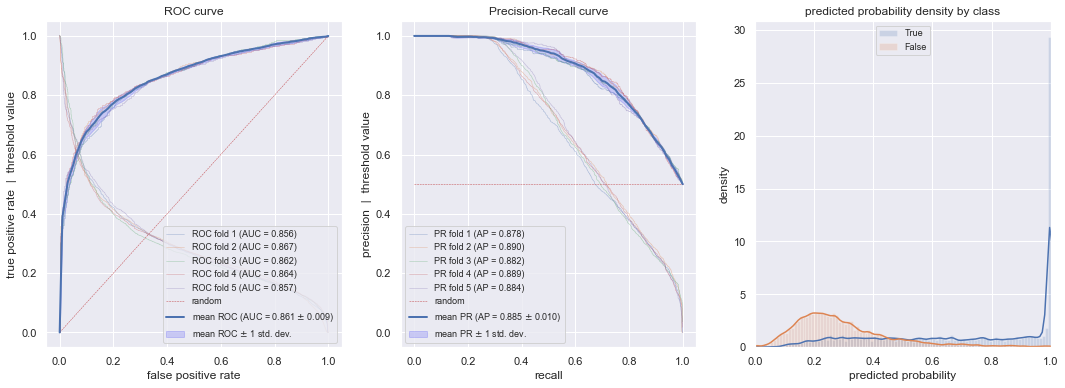

**sampling_2**

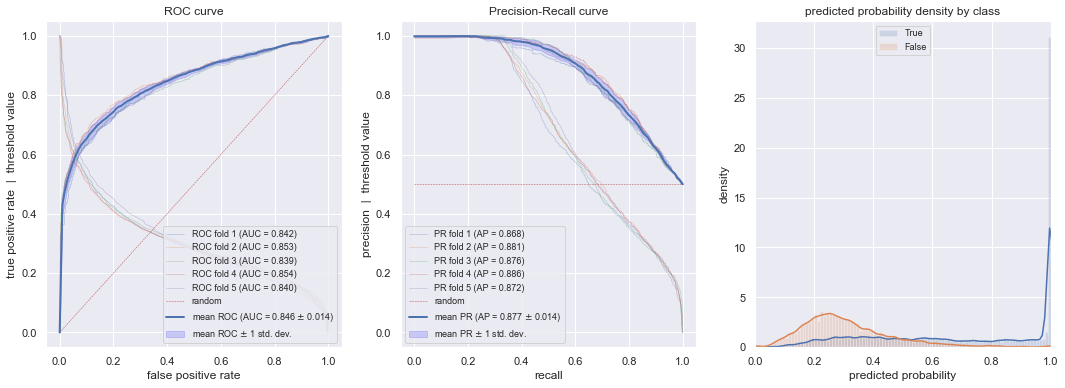

**sampling_3**

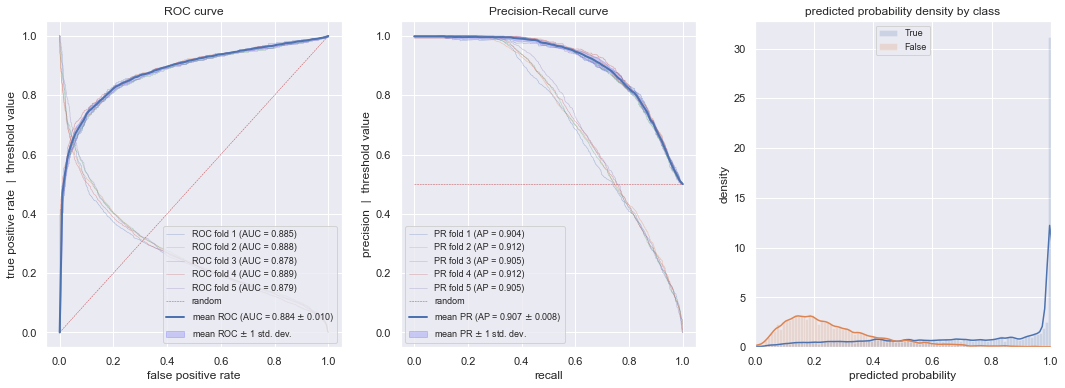

In [25]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_threshold_decision_metrics(dataset_dict[key]['metrics'], figsize=(18, 6))
    plt.show()

**sampling_1**

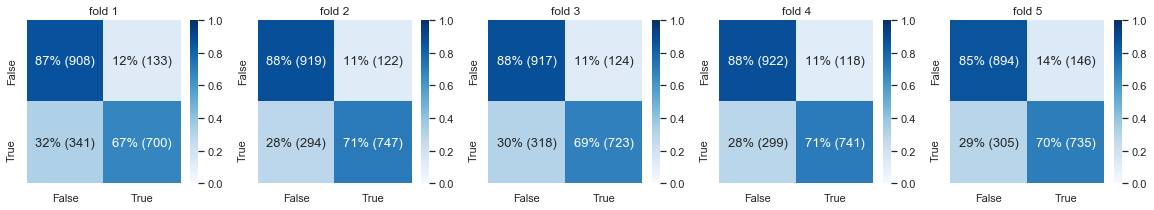

**sampling_2**

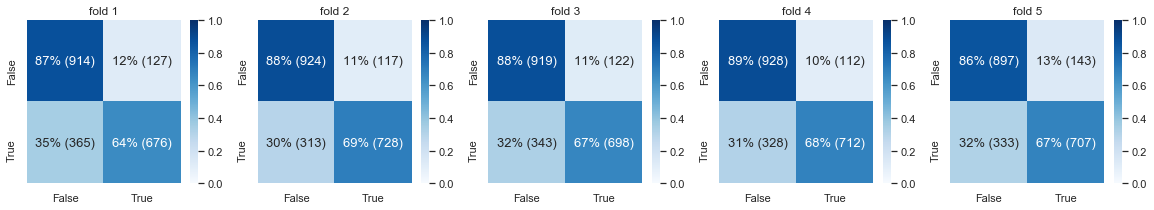

**sampling_3**

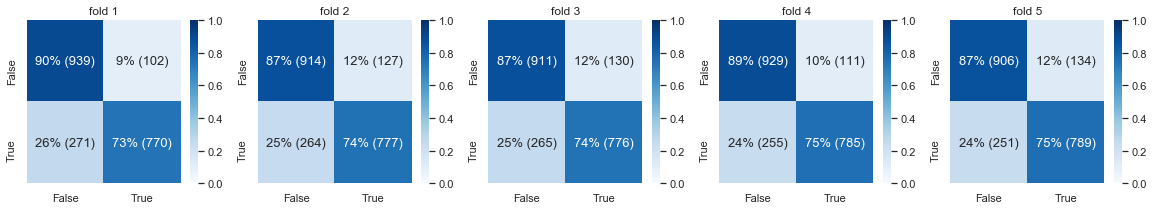

In [26]:
for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_confusion_matrix(dataset_dict[key]['metrics'])
    plt.show()

In [27]:
for key in dataset_dict.keys():
    add_metrics_to_summary(summary, dataset_dict[key]['metrics'], 'RidgeRegression_unified_%s' % key)

## Random Forest  - unified IMPACT

### Create job

In [48]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_unified_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs'))

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_unified_sampling_1


<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_unified_sampling_2


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ created

➞ mkdir on local computer ../ssh_remote_jobs/job_RandomForest_unified_sampling_3


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ created

In [29]:
job_list = []
for key in dataset_dict.keys():
    job_list.append(Selene_Job('RandomForest_unified_%s' % key, 'guilminp', '/home/guilminp/impact-annotator', '../ssh_remote_jobs', load_from_id=True))

<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ job found and reloaded

<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ job found and reloaded

In [61]:
for job in job_list:
    job.load_data(dataset_dict[job.job_id[21:]]['X'], dataset_dict[job.job_id[21:]]['y'])

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_unified_sampling_1


<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_unified_sampling_2


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ data loaded

➞ save X.pkl & y.pkl in ../ssh_remote_jobs/job_RandomForest_unified_sampling_3


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ data loaded

In [62]:
%%writefile {job_list[0].script_path}

# load the ml_tools functions
%run ../../ml_tools.py

# load the features matrix and target array
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

# setup cross-validation and import modules
from sklearn.model_selection import StratifiedKFold
cv_strategy = StratifiedKFold(n_splits=5)
nested_cv_strategy = StratifiedKFold(n_splits=3)

# choose a model and run it
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parameters_grid = [
    {'n_estimators': [100, 500, 1000, 1500], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50]}
]
model = GridSearchCV(RandomForestClassifier(random_state=42), parameters_grid, cv=nested_cv_strategy, scoring='roc_auc', refit=True, return_train_score=True)
metrics = run_model(model, X, y, cv_strategy, n_jobs=10)

# save the metrics
print('Save metrics...', end='')
metrics.to_pickle('metrics.pkl')
print(' done!')

Writing ../ssh_remote_jobs/job_RandomForest_unified_sampling_1/script.ipy


In [63]:
!cp {job_list[0].script_path} {job_list[1].script_path}
!cp {job_list[0].script_path} {job_list[2].script_path}

In [64]:
for job in job_list:
    job.run(n_jobs=10, short_job=True, memory=16)

➞ scp ../ssh_remote_jobs/job_RandomForest_unified_sampling_1 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  925     1.4KB/s   00:00    
X.pkl                                         100% 2364KB   2.3MB/s   00:01    
y.pkl                                         100%   11KB  27.9KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_1
Job <28727221> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_unified_sampling_1 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_unified_sampling_2 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  925     1.7KB/s   00:00    
X.pkl                                         100% 2364KB   2.3MB/s   00:01    
y.pkl                                         100%   11KB  28.0KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_2
Job <28727266> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_unified_sampling_2 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ submitted<br>

➞ scp ../ssh_remote_jobs/job_RandomForest_unified_sampling_3 to guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs
script.ipy                                    100%  925     2.4KB/s   00:00    
X.pkl                                         100% 2364KB   2.3MB/s   00:01    
y.pkl                                         100%   11KB  22.5KB/s   00:00    
➞ logged in /home/guilminp on selene.cbio.private
➞ load ~/.bash_profile
Hi Pierre!
➞ work on impact-annotator_env python virtualenv
➞ rm metrics.pkl & job_output.txt in /home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_3
Job <28727316> is submitted to default queue <sol>.
➞ bsub command used: $ bsub -o job_output.txt -J RandomForest_unified_sampling_3 -We 59 -n 10 -R "span[ptile=5,mem=16]" "ipython script.ipy"


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ submitted<br>

In [30]:
for job in job_list:
    job.get_results()

<span style="color:green">Job < RandomForest_unified_sampling_1 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_1 to ../ssh_remote_jobs/job_RandomForest_unified_sampling_1
metrics.pkl                                   100%  379KB   6.6MB/s   00:00    
job_output.txt                                100% 1554   566.7KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.838 ± 0.005
▴ Mean ROC AUC     : 0.916 ± 0.004
▴ Mean F1-score    : 0.833 ± 0.008
▴ Average precision: 0.929 ± 0.004


<span style="color:green">Job < RandomForest_unified_sampling_2 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_2 to ../ssh_remote_jobs/job_RandomForest_unified_sampling_2
metrics.pkl                                   100%  389KB   6.1MB/s   00:00    
job_output.txt                                100% 1555   317.6KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.831 ± 0.022
▴ Mean ROC AUC     : 0.904 ± 0.010
▴ Mean F1-score    : 0.823 ± 0.024
▴ Average precision: 0.918 ± 0.011


<span style="color:green">Job < RandomForest_unified_sampling_3 >: </span>✅ finished<br>

➞ scp metrics.pkl & job_output.txt from guilminp@selene.mskcc.org:/home/guilminp/impact-annotator/analysis/prediction/ssh_remote_jobs/job_RandomForest_unified_sampling_3 to ../ssh_remote_jobs/job_RandomForest_unified_sampling_3
metrics.pkl                                   100%  390KB   6.8MB/s   00:00    
job_output.txt                                100% 1554   622.2KB/s   00:00    
➞ load metrics.pkl in pandas dataframe self.metrics
➞ print main results
▴ Mean accuracy    : 0.856 ± 0.009
▴ Mean ROC AUC     : 0.926 ± 0.008
▴ Mean F1-score    : 0.852 ± 0.010
▴ Average precision: 0.936 ± 0.005


**RandomForest_unified_sampling_1**

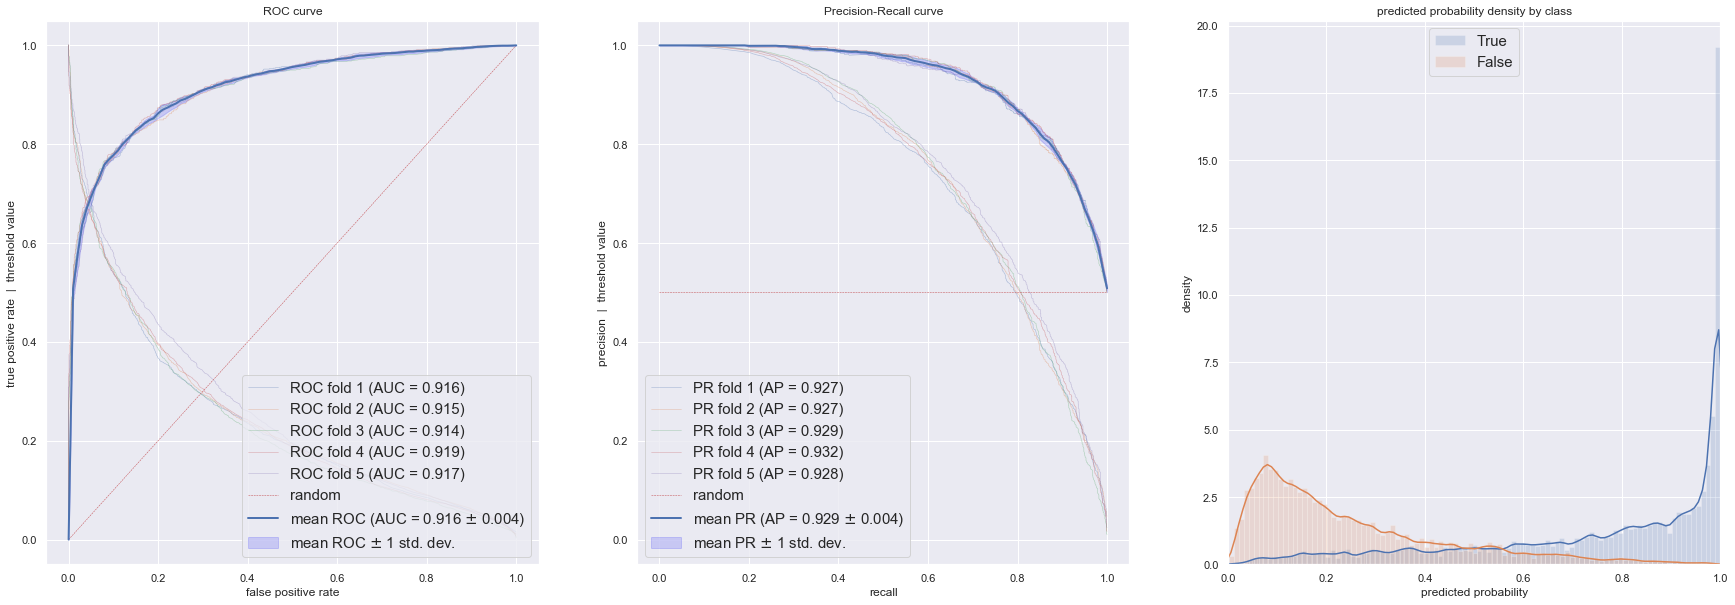

**RandomForest_unified_sampling_2**

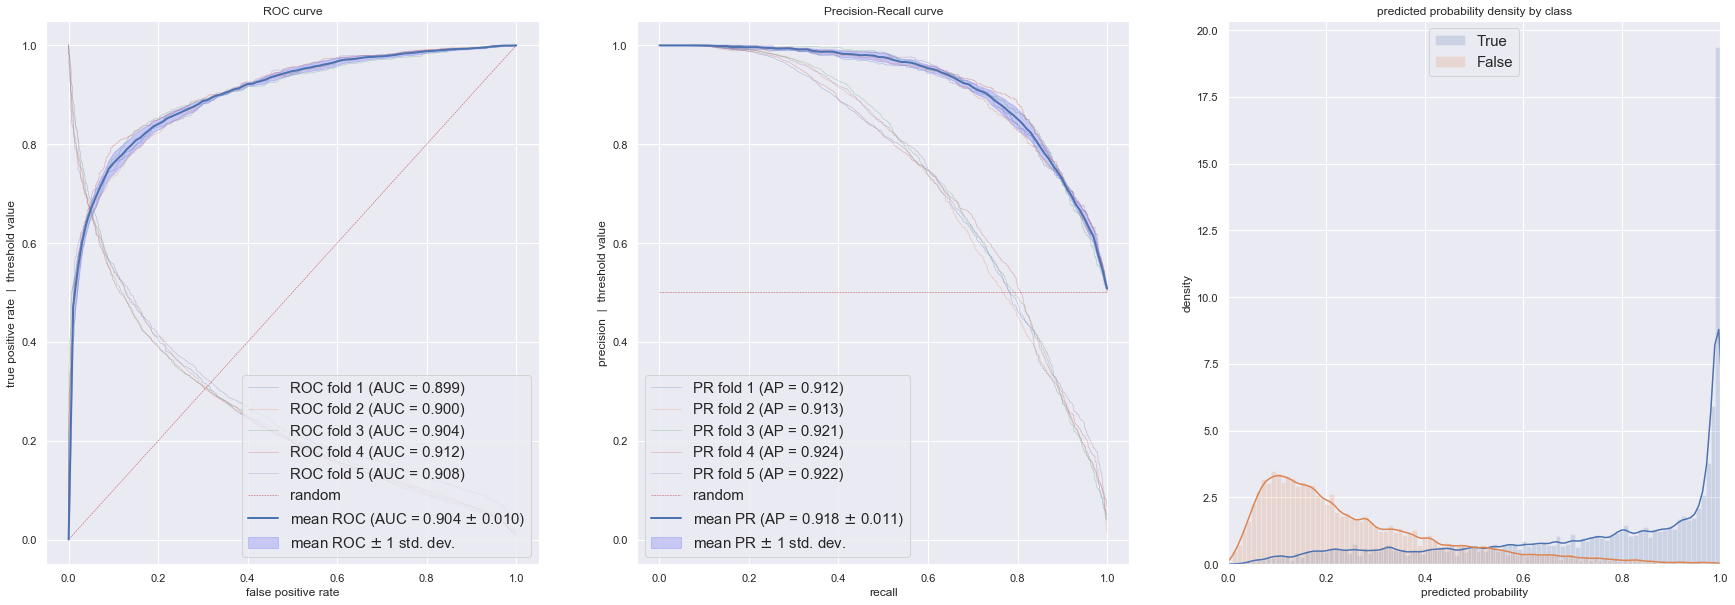

**RandomForest_unified_sampling_3**

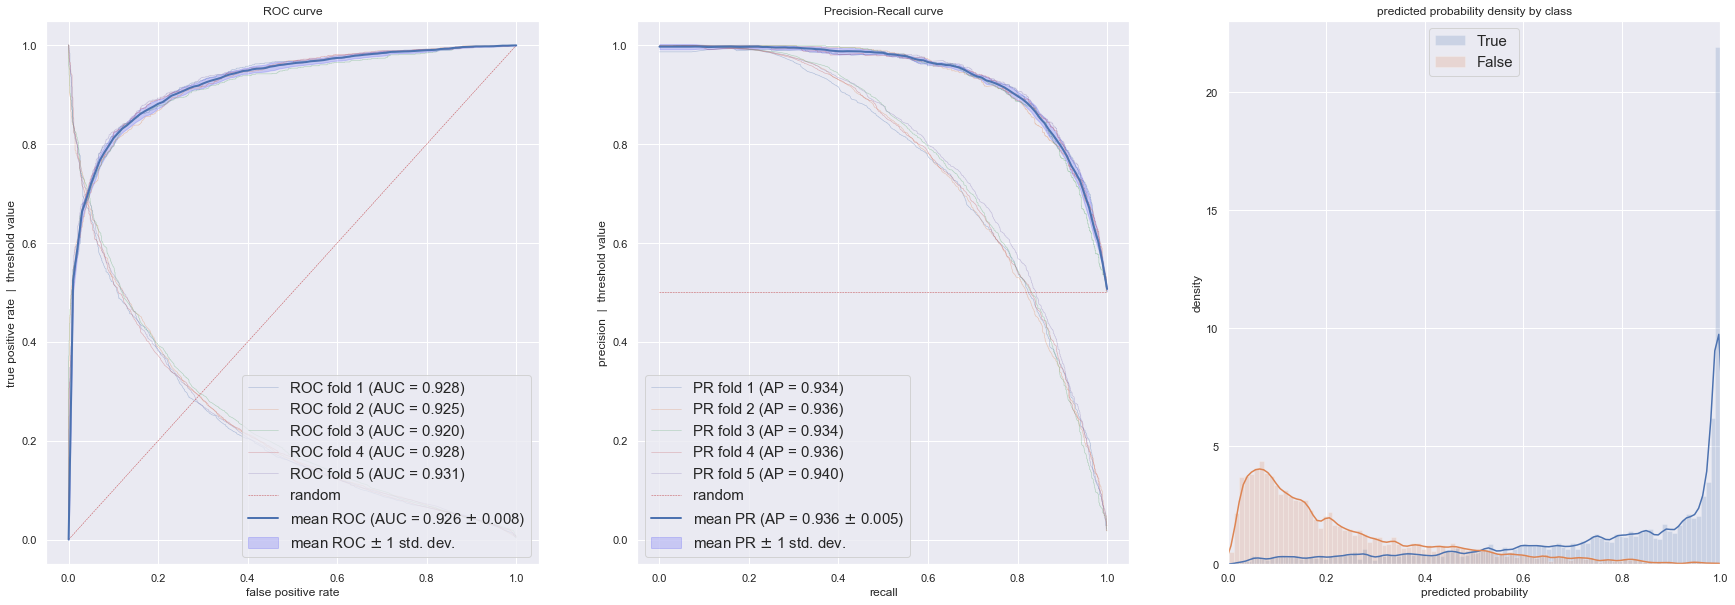

In [31]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_threshold_decision_metrics(job.metrics)
        plt.show()

**RandomForest_unified_sampling_1**

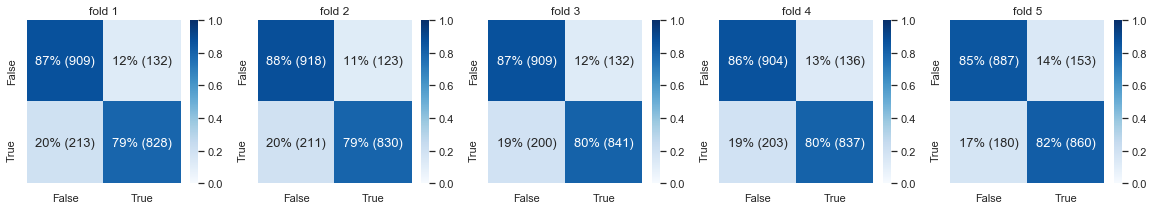

**RandomForest_unified_sampling_2**

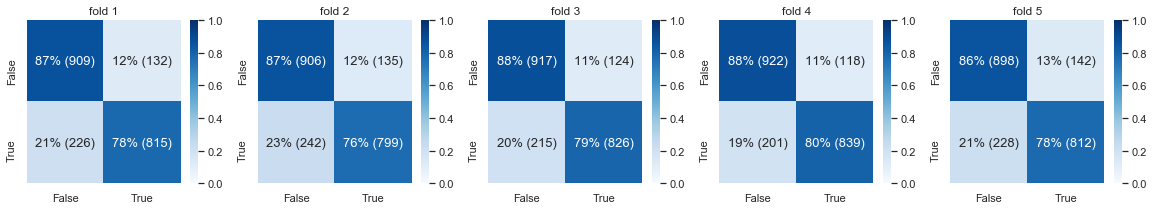

**RandomForest_unified_sampling_3**

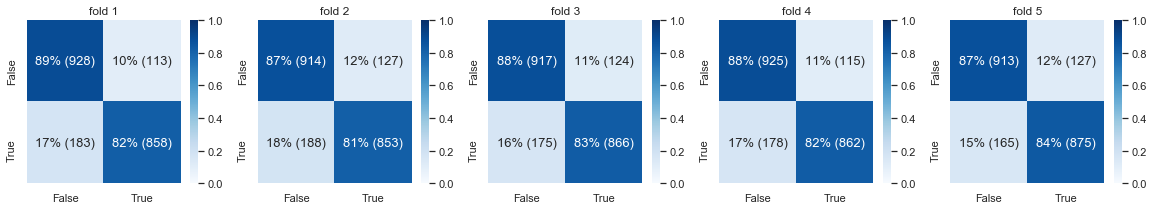

In [32]:
for job in job_list:
    if hasattr(job, 'metrics'):
        print_md('**' + job.job_id + '**')
        plot_confusion_matrix(job.metrics)
        plt.show()

In [33]:
for job in job_list:
    if hasattr(job, 'metrics'):
        add_metrics_to_summary(summary, job.metrics, job.job_id)

### Study feature importance of the best hyperparameted classifier

**sampling_1**

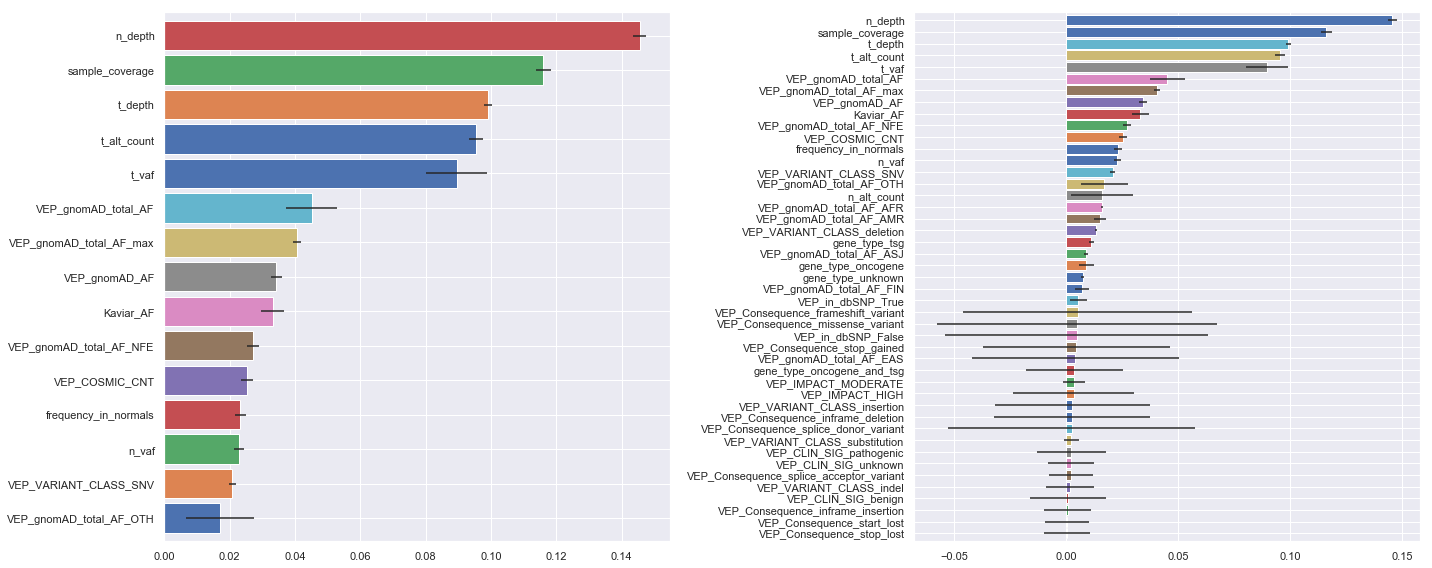

**sampling_2**

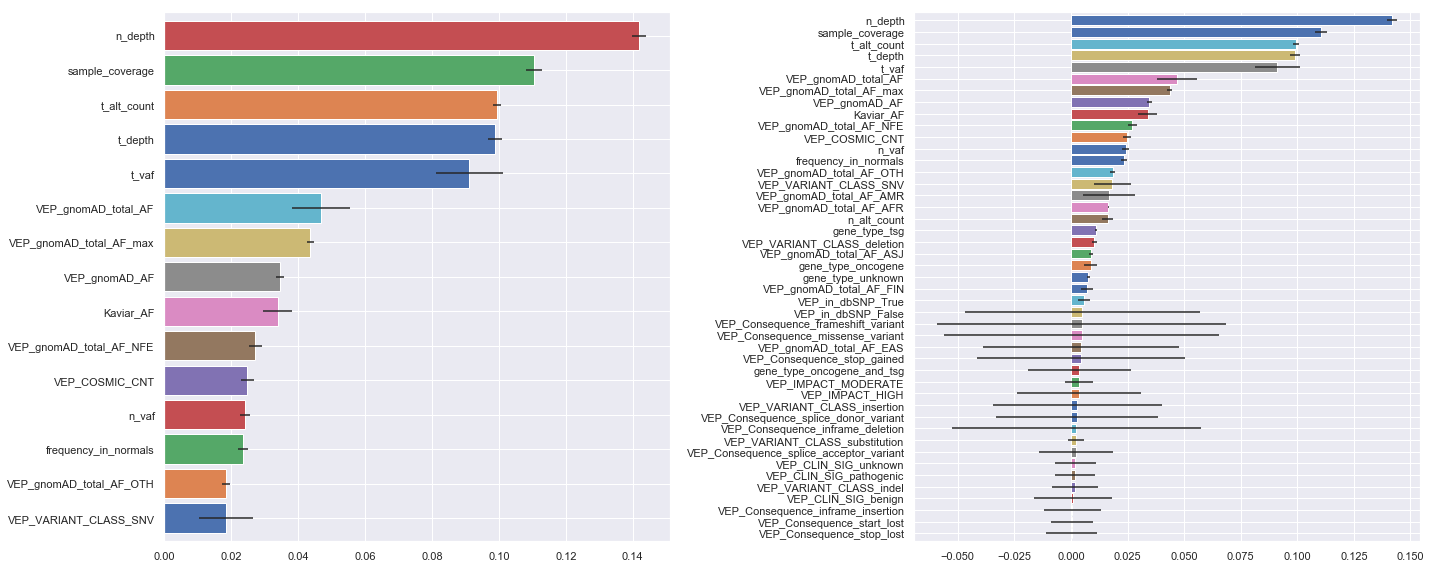

**sampling_3**

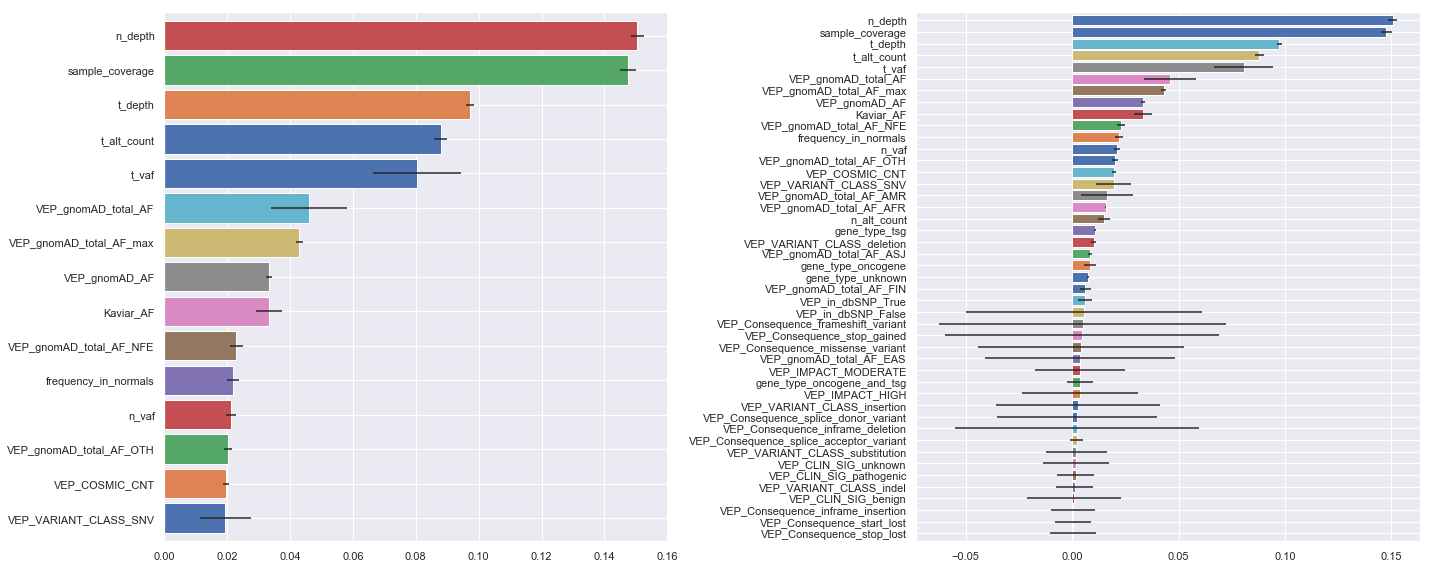

In [34]:
from sklearn.ensemble import RandomForestClassifier

model_bestRF = RandomForestClassifier(random_state=42, n_estimators=1000, max_depth=30, criterion='entropy', n_jobs=5)

for key in dataset_dict.keys():
    print_md('**' + key + '**')
    plot_features_importance(model_bestRF, dataset_dict[key]['X'], dataset_dict[key]['y'], random_forest=True)
    plt.show()

## Summary

In [59]:
summary = pd.read_pickle('summary_sampling_comparison.pkl')

,test_accuracy_mean,test_f1_mean,test_roc_auc_mean,test_average_precision_mean
sampling_strategy,,,,
RidgeRegression_sampling_1,0.82,0.803,0.891,0.912
RidgeRegression_sampling_2,0.819,0.801,0.887,0.912
RidgeRegression_sampling_3,0.866,0.858,0.926,0.943
RandomForest_sampling_1,0.864,0.859,0.937,0.948
RandomForest_sampling_2,0.86,0.853,0.933,0.944
RandomForest_sampling_3,0.896,0.894,0.958,0.964
RidgeRegression_unified_sampling_1,0.789,0.768,0.861,0.885
RidgeRegression_unified_sampling_2,0.779,0.753,0.846,0.877
RidgeRegression_unified_sampling_3,0.816,0.803,0.884,0.907


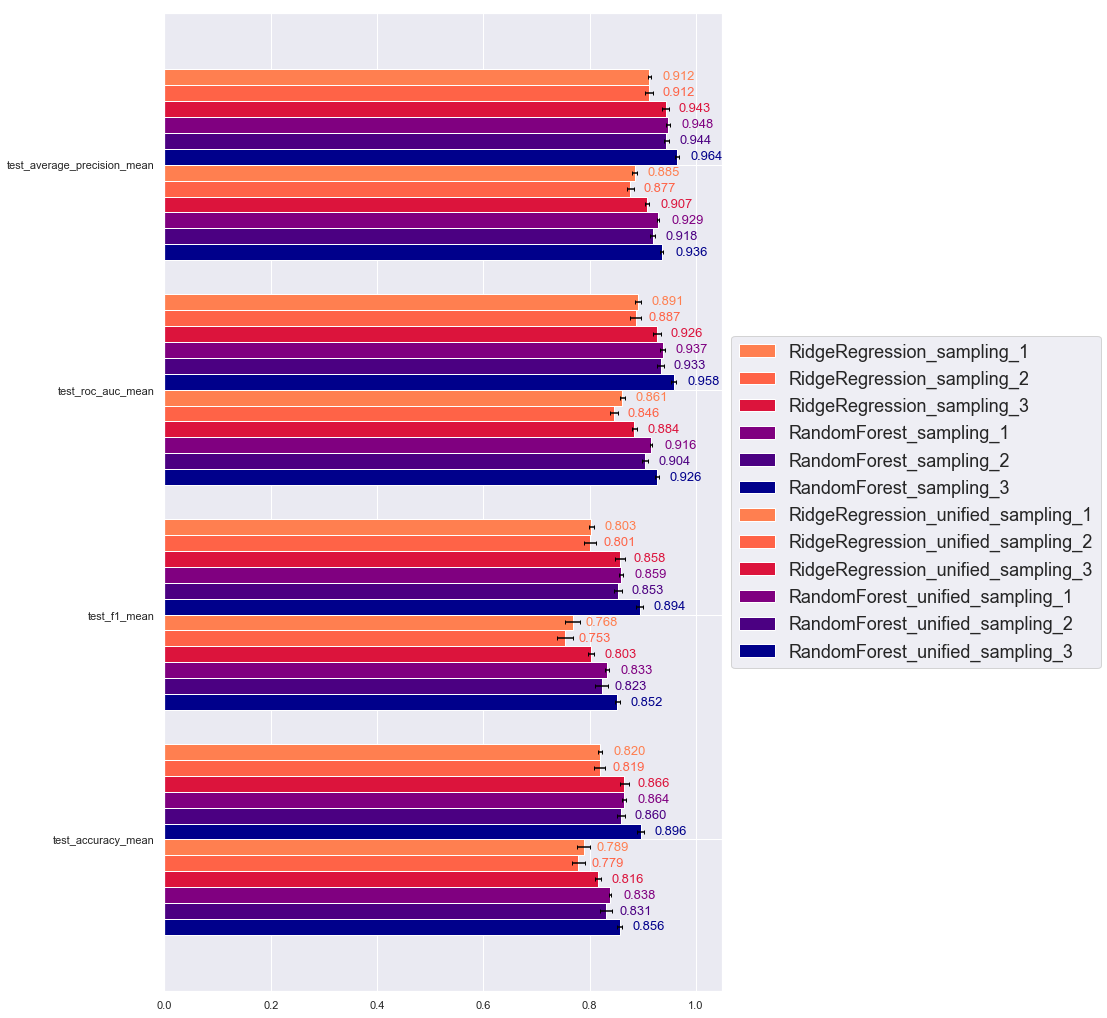

In [60]:
compare_models(summary, ['darkblue', 'indigo', 'purple', 'crimson', 'tomato', 'coral'], figsize=(10, 18))

In [58]:
summary.to_pickle('summary_sampling_comparison.pkl')

## Differences between sampling

In [3]:
def get_negative_class(seed):
    positive_class_number = impact[impact.is_artefact].shape[0]
    return impact[~impact.is_artefact].iloc[seed * positive_class_number:(seed + 1) * positive_class_number]

In [4]:
impact = pd.read_csv('../../../data/annotated_final_IMPACT_mutations_180508.txt', sep='\t', low_memory=False)
impact['is_artefact'] = impact.confidence_class == "UNLIKELY"
    
sampling_1 = get_negative_class(0)
sampling_2 = get_negative_class(1)
sampling_3 = get_negative_class(2)

sampling_1['sampling'] = 'sampling_1'
sampling_2['sampling'] = 'sampling_2'
sampling_3['sampling'] = 'sampling_3'
data = pd.concat([sampling_1, sampling_2, sampling_3])

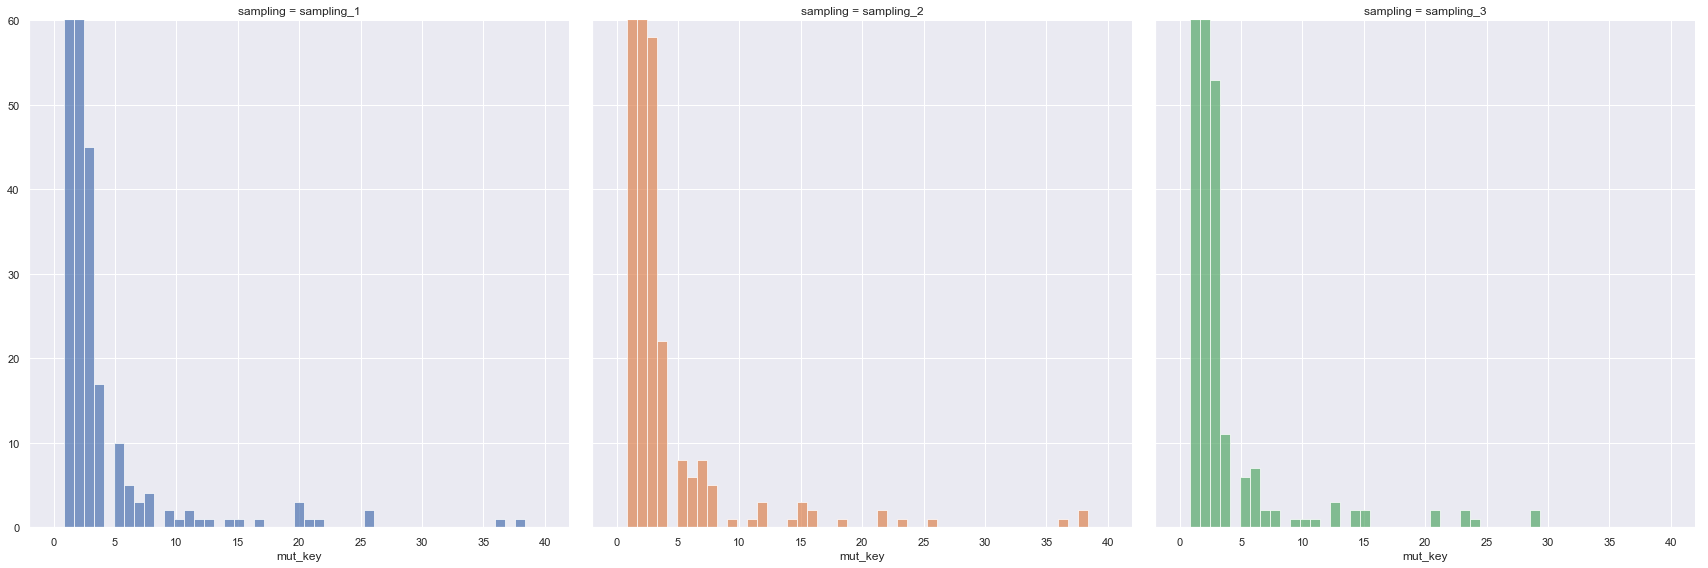

In [5]:
aggregation = {
    'mut_key': 'count',
    'sampling': lambda x: x.iloc[0]
}

grid = seaborn.FacetGrid(data.groupby(['sampling', 'mut_key']).aggregate(aggregation), col='sampling', hue='sampling', margin_titles=True, height=8)
grid.map(plt.hist, 'mut_key', bins=np.linspace(0, 40, 50), alpha=0.7)
plt.ylim(0, 60);

/Users/guilminp/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


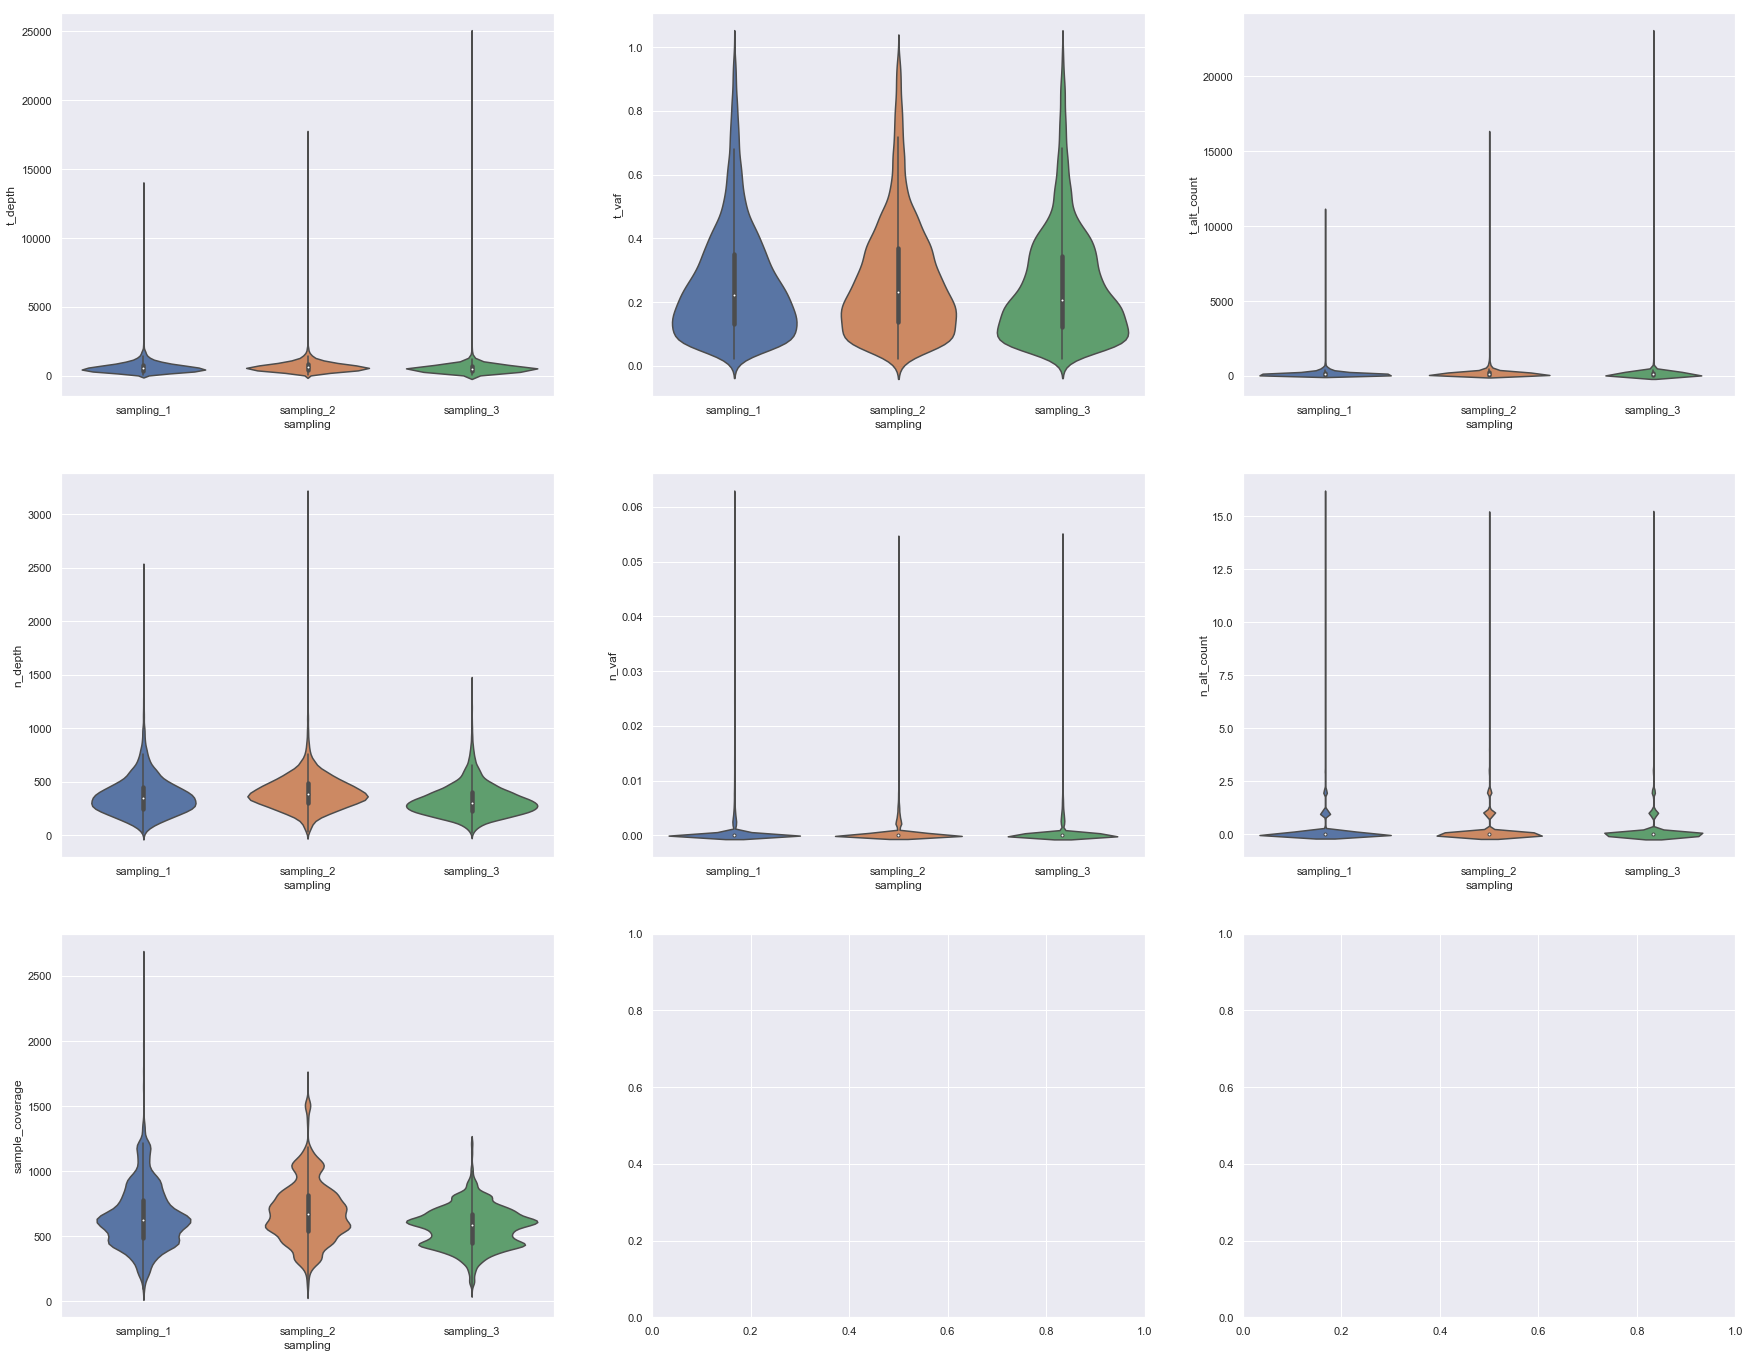

In [6]:
fig, ax = plt.subplots(3, 3, figsize=(30, 24))

for i, feature in enumerate(['t_depth', 't_vaf', 't_alt_count',
                             'n_depth', 'n_vaf', 'n_alt_count', 'sample_coverage']):
    #seaborn.catplot(data=data, x='sampling', y=feature, kind='box', flierprops={'marker': 'o', 'markersize': 3}, ax=ax[i // 3, i % 3]);
    seaborn.catplot(data=data, x='sampling', y=feature, kind='violin', ax=ax[i // 3, i % 3])
    plt.close(2)

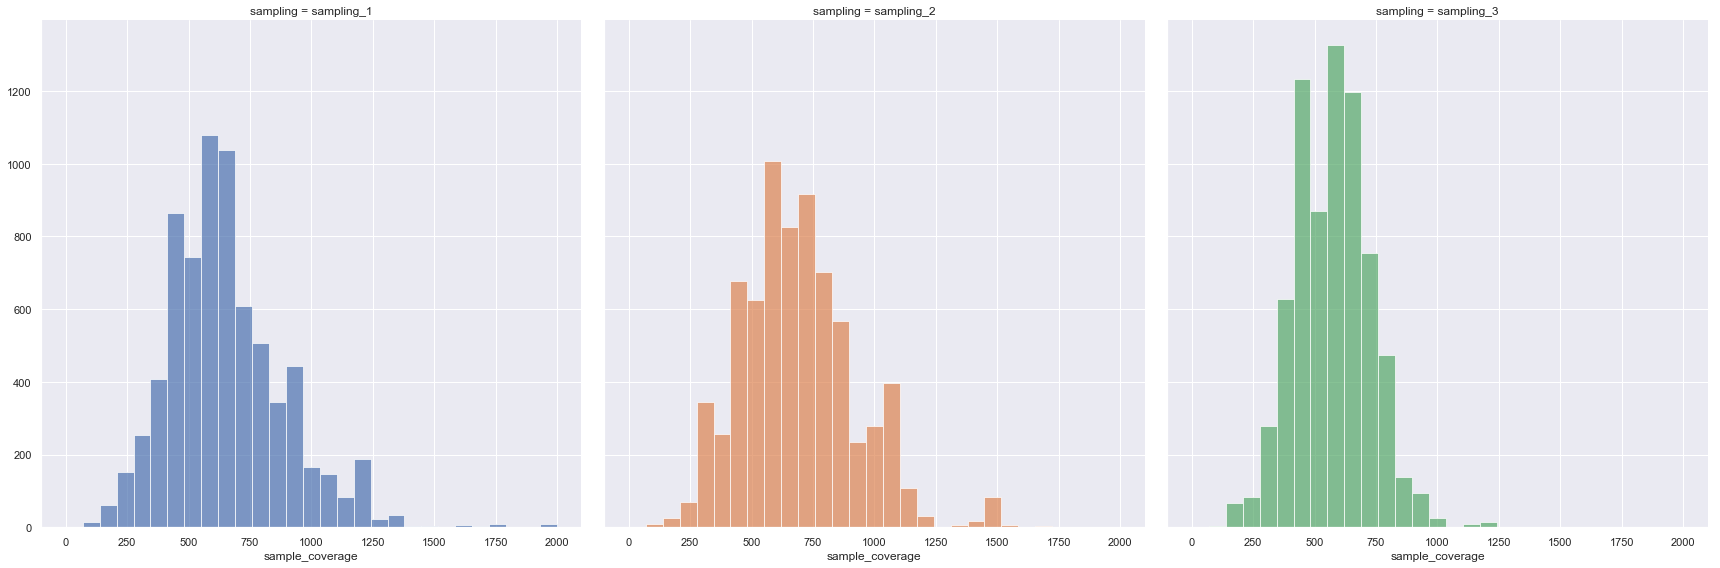

In [7]:
grid = seaborn.FacetGrid(data, col='sampling', hue='sampling', margin_titles=True, height=8)
grid.map(plt.hist, 'sample_coverage', bins=np.linspace(0, 2000, 30), alpha=0.7);

In [8]:
data[data.frequency_in_normals > 0]

,Hugo_Symbol,Chromosome,Start_Position,End_Position,Consequence,Variant_Type,Reference_Allele,Tumor_Seq_Allele2,Tumor_Sample_Barcode,cDNA_change,HGVSp_Short,t_depth,t_vaf,t_alt_count,n_depth,n_vaf,n_alt_count,t_ref_plus_count,t_ref_neg_count,t_alt_plus_count,t_alt_neg_count,confidence_class,sample_coverage,mut_key,VAG_VT,VAG_GENE,VAG_cDNA_CHANGE,VAG_PROTEIN_CHANGE,VAG_EFFECT,VEP_Consequence,VEP_SYMBOL,VEP_HGVSc,VEP_HGVSp,VEP_Amino_acids,VEP_VARIANT_CLASS,VEP_EXON,VEP_INTRON,VEP_IMPACT,VEP_CLIN_SIG,VEP_COSMIC_CNT,VEP_gnomAD_AF,sample_mut_key,patient_key,frequency_in_normals,VEP_SIFT_class,VEP_SIFT_score,VEP_PolyPhen_class,VEP_PolyPhen_score,VEP_in_dbSNP,VEP_gnomAD_total_AF_AFR,VEP_gnomAD_total_AF_AMR,VEP_gnomAD_total_AF_ASJ,VEP_gnomAD_total_AF_EAS,VEP_gnomAD_total_AF_FIN,VEP_gnomAD_total_AF_NFE,VEP_gnomAD_total_AF_OTH,VEP_gnomAD_total_AF_max,VEP_gnomAD_total_AF,Kaviar_AF,is_a_hotspot,is_a_3d_hotspot,oncogenic,gene_type,is_artefact,sampling


/Users/guilminp/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


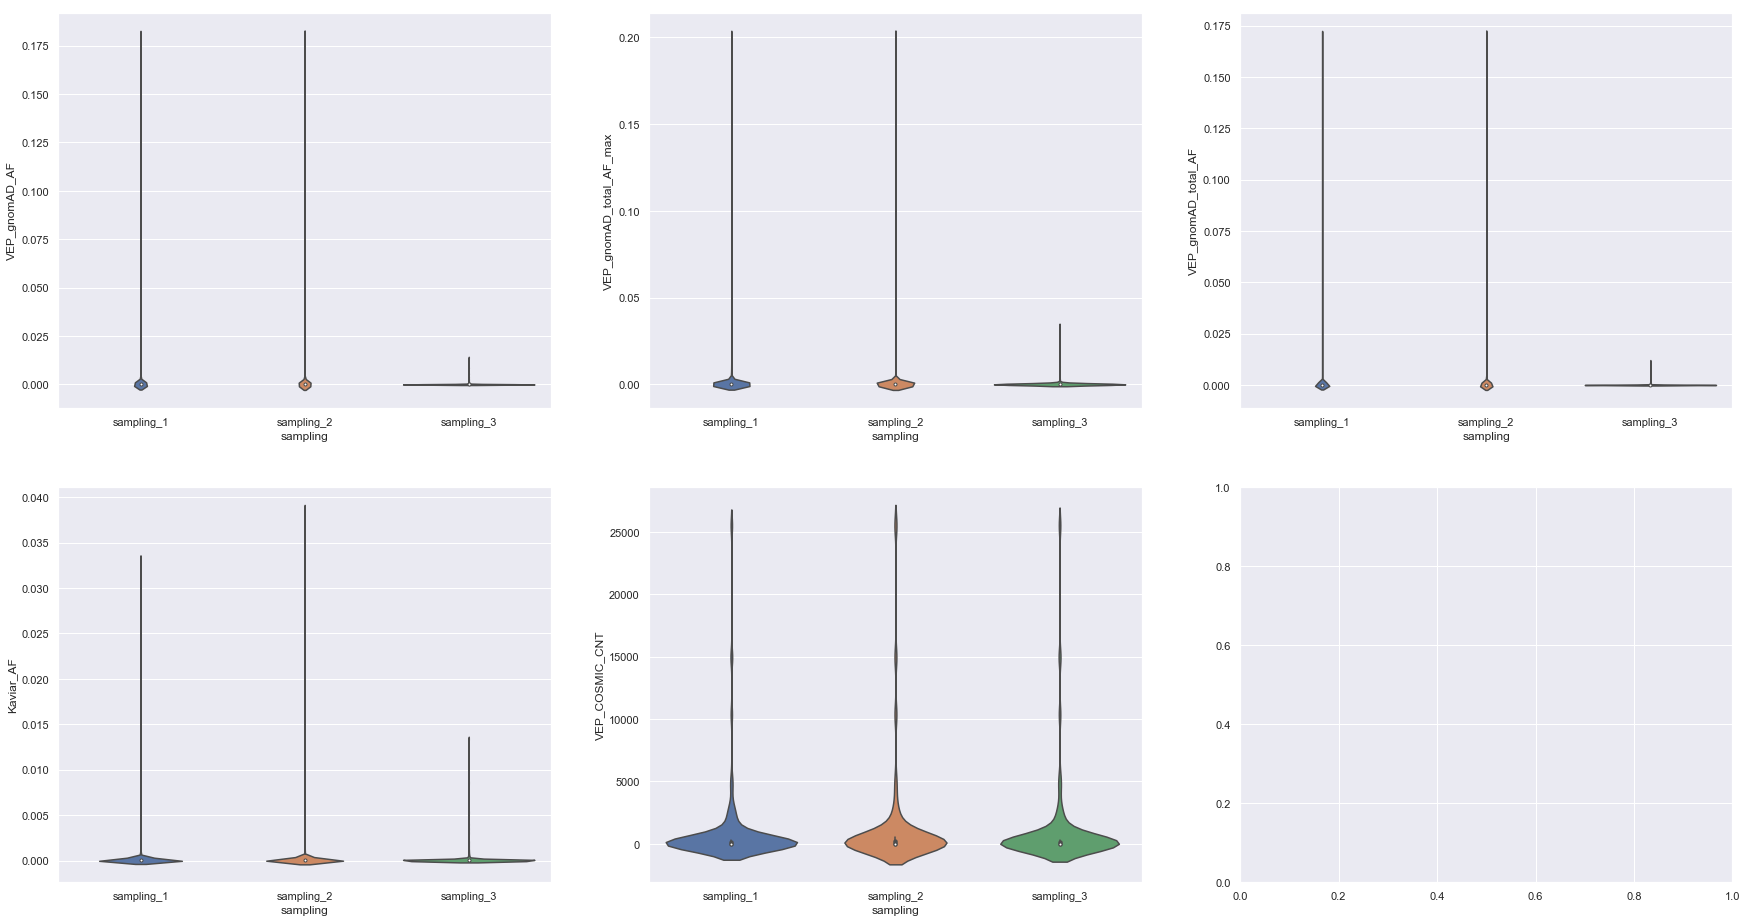

In [9]:
fig, ax = plt.subplots(2, 3, figsize=(30, 16))
for i, feature in enumerate(['VEP_gnomAD_AF', 'VEP_gnomAD_total_AF_max', 'VEP_gnomAD_total_AF',
                             'Kaviar_AF', 'VEP_COSMIC_CNT']):
    seaborn.catplot(data=data[data[feature] > 0], x='sampling', y=feature, kind='violin', ax=ax[i // 3, i % 3])
    plt.close(2)

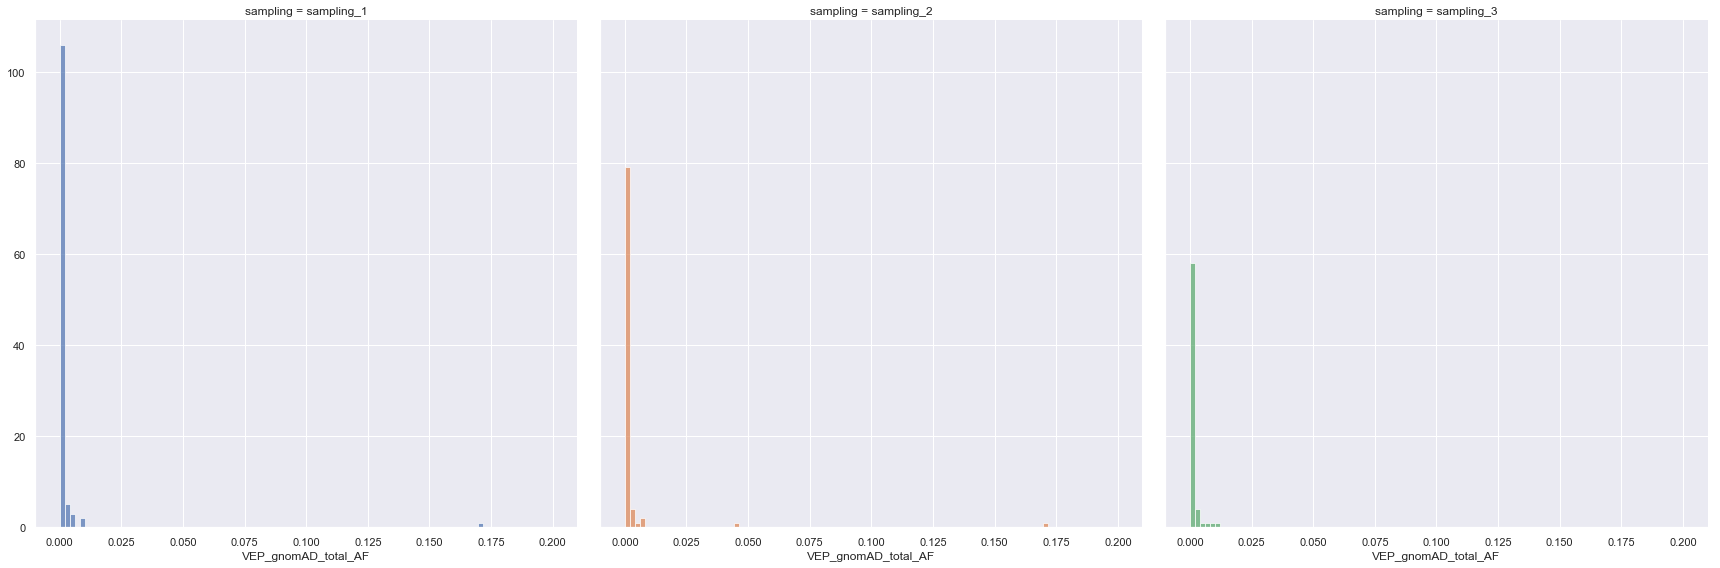

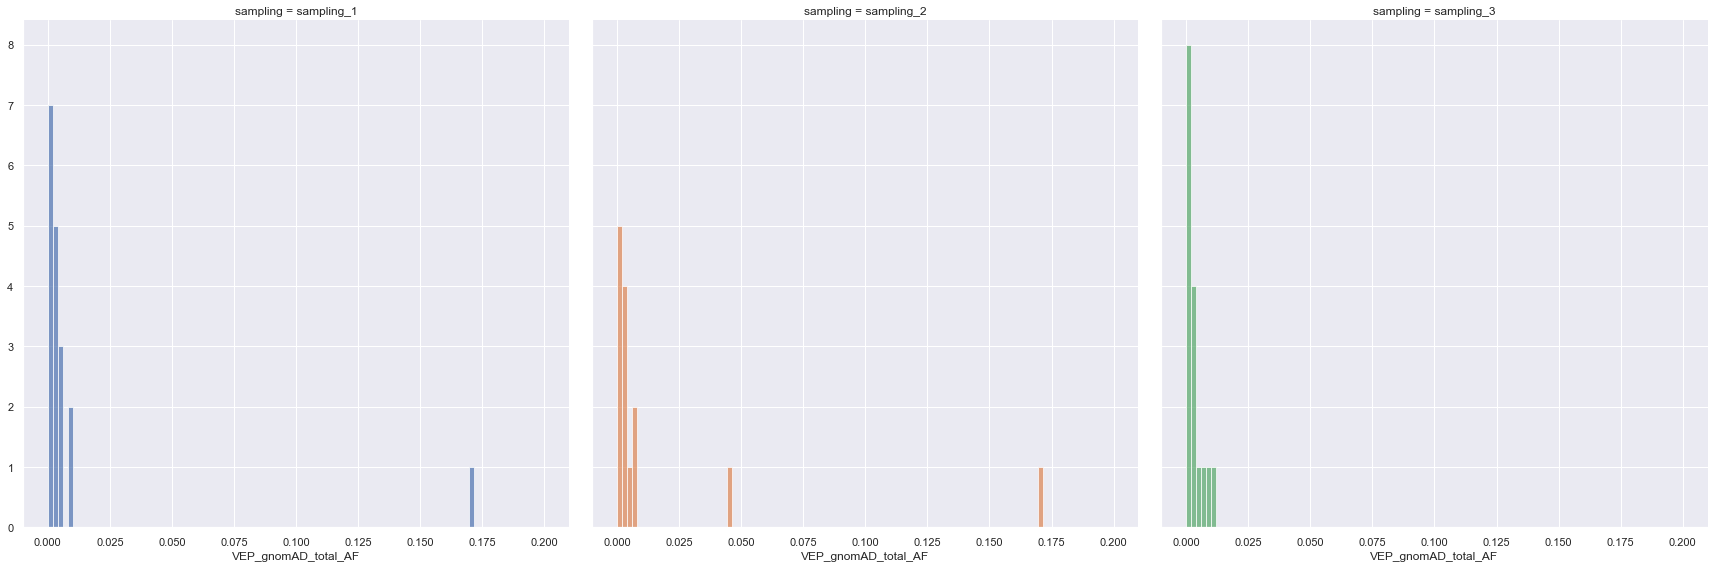

In [10]:
grid = seaborn.FacetGrid(data[data.VEP_gnomAD_total_AF > 0.0001], col='sampling', hue='sampling', margin_titles=True, height=8)
grid.map(plt.hist, 'VEP_gnomAD_total_AF', bins=np.linspace(0, 0.2, 100), alpha=0.7)
grid = seaborn.FacetGrid(data[data.VEP_gnomAD_total_AF > 0.001], col='sampling', hue='sampling', margin_titles=True, height=8)
grid.map(plt.hist, 'VEP_gnomAD_total_AF', bins=np.linspace(0, 0.2, 100), alpha=0.7);

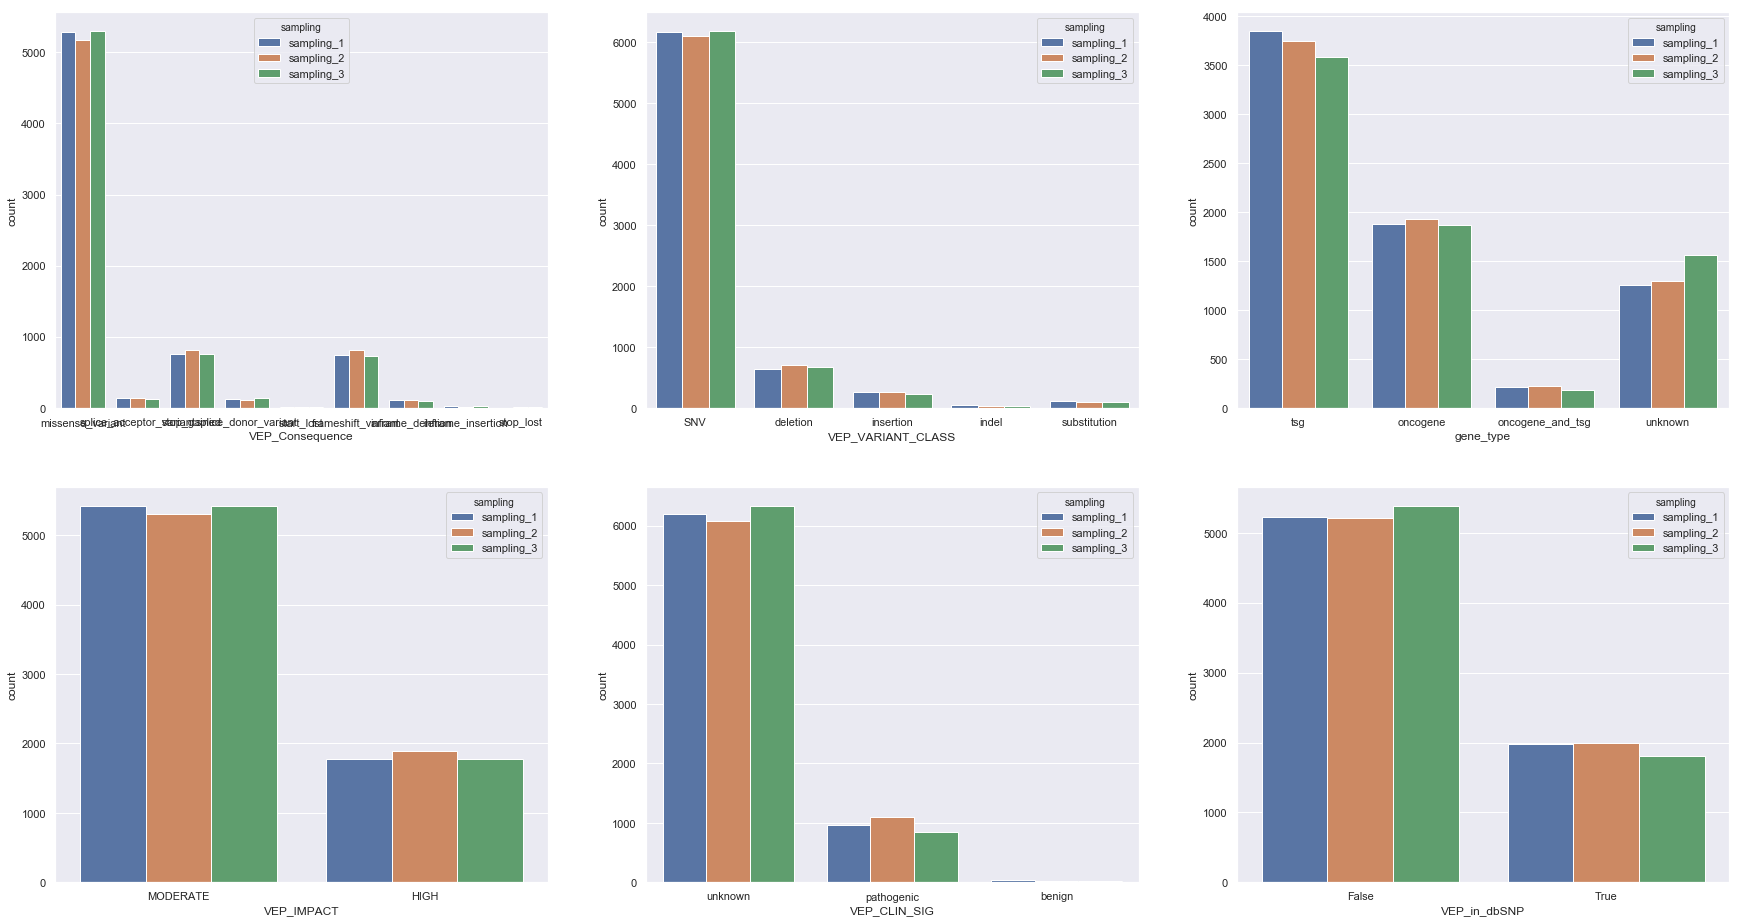

In [11]:
fig, ax = plt.subplots(2, 3, figsize=(30, 16))
for i, feature in enumerate(['VEP_Consequence', 'VEP_VARIANT_CLASS', 'gene_type',
                             'VEP_IMPACT', 'VEP_CLIN_SIG', 'VEP_in_dbSNP']):
    seaborn.catplot(data=data, hue='sampling', x=feature, kind='count', ax=ax[i // 3, i % 3])
    plt.close(2)